# Prediction of number of days an animal (dog-cat) will spend in the shelter before being addopted.

# Table of Contents
1. [Data cleaning and preparation](#1)
2. [EDA](#2)
3. [Model evaluation](#3)   
    3.1 [Features selection](#31)  
    3.2 [Training models](#32)  
        - 3.2.1 [Linear Regression](#321)  
        - 3.2.2 [Random Forest](#322)


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
# read prepared dataset
df = pd.DataFrame(pd.read_csv('data.csv'))

<h2 id="1">1. Data cleaning and preparation</h2>


Dataframe from source

In [3]:
df.head().T

,0,1,2,3,4
animal_id,A844350,A818975,A760053,A707375,A696408
name,*Ella,NaN,NaN,*Candy Cane,*Pearl
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 East William Cannon Drive in Austin (TX),Braker Lane And Metric in Travis (TX),8800 South First Street in Austin (TX),Galilee Court And Damita Jo Dr in Manor (TX),9705 Thaxton in Austin (TX)
intake_type,Stray,Stray,Stray,Stray,Stray
intake_condition,Normal,Normal,Normal,Normal,Normal
animal_type,Cat,Cat,Dog,Dog,Dog
sex_upon_intake,Intact Female,Intact Male,Intact Male,Intact Female,Intact Female
age_upon_intake,6 months,4 weeks,2 years,5 months,2 years
breed,Domestic Shorthair,Domestic Shorthair,Chihuahua Shorthair,Pit Bull,Chihuahua Shorthair


In [4]:
df.dtypes


animal_id           object
name                object
datetime_intake     object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
dtype: object

#### 1.1 Data types & formats inside df

In [5]:
# datetime columns: datetime_intake, datetime_outcome
datetime_columns = ['datetime_intake', 'datetime_outcome']
# convert the datetime columns to datetime type
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column])
datetime_columns

['datetime_intake', 'datetime_outcome']

In [6]:
# rest of the columns from dataframe that are not datetime categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

for column in categorical_columns:
    df[column] = df[column].str.lower()

#### 1.2 Target outcome calculation: days in the shelter.

In [7]:
# lets calculate our target variable
# the target variable is the difference between the datetime_outcome and datetime_intake
df['days_in_shelter'] = (df['datetime_outcome'] - df['datetime_intake']).dt.days

#### 1.3 Feature transformation: Clean categories with a lot of unique values

In [8]:
for column in categorical_columns:
    print(f'{column}: {df[column].nunique()} unique values')
    

animal_id: 71066 unique values
name: 19114 unique values
found_location: 31479 unique values
intake_type: 5 unique values
intake_condition: 14 unique values
animal_type: 2 unique values
sex_upon_intake: 5 unique values
age_upon_intake: 47 unique values
breed: 2049 unique values
color: 472 unique values
outcome_type: 1 unique values


- Divide the sex upon intake into sex and castrated status

In [9]:
def castrated_status(row):
    if 'neutered' in row or 'spayed' in row:
        return 'yes'
    else:
        return 'no'

def sex_upon_intake(row):
    if 'female' in row:
        return 'female'
    elif 'male' in row:
        return 'male'
    else:
        return 'unknown'

df['castrated'] = df['sex_upon_intake'].apply(castrated_status)
df['sex_upon_intake'] = df['sex_upon_intake'].apply(sex_upon_intake) 


- Convert age_upon_intake in months 

In [10]:
df.age_upon_intake.value_counts().head()

age_upon_intake
1 month     12679
1 year      11399
2 years     10399
2 months     7718
3 years      3558
Name: count, dtype: int64

In [11]:
def convert_to_months(age):
    # Split the age into value and unit
    parts = age.split()
    if len(parts) != 2:  # Handle unexpected formats
        return None
    
    value, unit = int(parts[0]), parts[1].lower()
    
    # Convert the age to months
    if 'year' in unit:
        return value * 12
    elif 'month' in unit:
        return value 
    elif 'week' in unit:
        return value / 4
    elif 'day' in unit:
        return value / 30
    else:
        return None  # Handle unknown units

# Apply the function to the column and create a new column
df['age_in_months'] = df['age_upon_intake'].apply(convert_to_months)

# Check the resulting DataFrame
print(df[['age_upon_intake', 'age_in_months']].head())


  age_upon_intake  age_in_months
0        6 months            6.0
1         4 weeks            1.0
2         2 years           24.0
3        5 months            5.0
4         2 years           24.0


In [12]:
print(df['age_in_months'].describe())


count    78114.000000
mean        17.555204
std         27.409292
min        -48.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64


we can see animals with ages below 0. Lets look at them

In [13]:
df[df['age_in_months']<0]   


,animal_id,name,datetime_intake,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type,days_in_shelter,castrated,age_in_months
4305,a725472,rascal,2019-02-26 11:25:00,austin (tx),owner surrender,normal,dog,male,-1 years,chihuahua shorthair mix,white/brown,2019-02-26 14:34:00,adoption,0,yes,-12.0
12481,a725472,rascal,2016-06-12 14:16:00,austin (tx),owner surrender,aged,dog,male,-3 years,chihuahua shorthair mix,white/brown,2016-07-24 15:54:00,adoption,42,yes,-36.0
19789,a783723,pina,2018-11-05 11:00:00,3108 crownover street in austin (tx),stray,normal,cat,female,-4 years,domestic shorthair,white/orange,2018-11-12 11:53:00,adoption,7,no,-48.0


as I assume there are errors, I will remove the -

In [14]:
# remove from age the ¨-¨ character
df['age_in_months'] = df['age_in_months'].abs()

In [15]:
df['age_in_months'].describe()

count    78114.000000
mean        17.557662
std         27.407717
min          0.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64

* Breed

In [16]:
df['breed'].value_counts().head()

breed
domestic shorthair mix     15248
domestic shorthair         12372
labrador retriever mix      4632
pit bull mix                3946
chihuahua shorthair mix     3253
Name: count, dtype: int64

In [17]:
# Split the breed column into individual words
all_words = df['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)
 
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 80 # I decided to use 80% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
important_words_df = word_freq_df[word_freq_df['Cumulative Percentage'] <= percentage_limit]
 
print(f"Important Words in Breeds (% {percentage_limit} Cumulative Importance):")
print(important_words_df)


Important Words in Breeds (% 80 Cumulative Importance):
          Word  Frequency  Percentage  Cumulative Percentage
5          mix      47360   22.478310              22.478310
1    shorthair      32589   15.467602              37.945912
0     domestic      31730   15.059898              53.005809
11   retriever       7095    3.367475              56.373284
12    labrador       7070    3.355609              59.728893
4         bull       6379    3.027642              62.756536
3          pit       6128    2.908511              65.665047
2    chihuahua       5198    2.467108              68.132155
29    shepherd       4961    2.354622              70.486777
28      german       3932    1.866231              72.353008
15     terrier       3335    1.582879              73.935887
39        hair       2910    1.381163              75.317050
38      medium       2820    1.338447              76.655497
8   australian       2803    1.330378              77.985875
9       cattle       2143    

In the table above we can see the words inside breeds that appears in 80% of the records.  
There are somo common properties that would be separated creating more features: 
* extract the hairtype in another column
* separate the mix as separate propertie
* separate miniature
* separate domestic

In [18]:
# 'hair_type'
df['hair_type'] = df['breed'].apply(
    lambda x: 'long' if 'longhair' in x else 'short' if 'shorthair' in x
      else 'medium' if 'medium hair' in x else 'unknown')

df['hair_type'].value_counts()


hair_type
unknown    40178
short      33245
medium      2820
long        1871
Name: count, dtype: int64

In [19]:
# mix breed column
df['mix_breed'] = df['breed'].apply(lambda x: 'mix' if 'mix' in x else 'not mix')

In [20]:
# miniature breed column
df['miniature'] = df['breed'].apply(lambda x: 'miniature' if 'miniature' in x else 'non-miniature')

In [21]:
# domestic breed column
df['domestic'] = df['breed'].apply(lambda x: 'domestic' if 'domestic' in x else 'non-domestic')

After creating these features, let's remove these wordsd from the breed column

In [22]:
words_to_remove = ['mix', 'shorthair', 'longhair', 'medium hair', 'miniature', 'domestic','dog','cat']
for word in words_to_remove:
    df['breed'] = df['breed'].str.replace(word, '').str.strip()

Get the pair combinations of names inside breed so as to identify common ones.

In [23]:
# Tokenize each row in the breed column
df['breed_tokenized'] = df['breed'].str.split()
word_pairs = df['breed_tokenized'].apply(lambda x: list(combinations(x, 2)))

all_pairs = [pair for pairs in word_pairs for pair in pairs]

pair_counts = Counter(all_pairs)
pair_freq_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Frequency']).sort_values(by='Frequency', ascending=False)
total_pairs = pair_freq_df['Frequency'].sum()
pair_freq_df['Percentage'] = (pair_freq_df['Frequency'] / total_pairs) * 100
pair_freq_df['Cumulative Percentage'] = pair_freq_df['Percentage'].cumsum()

target_percentage = 0.8  # I decided to use 80% as the limit to cover the most important pairs
frequent_pairs_df = pair_freq_df[pair_freq_df['Percentage'] >= target_percentage]
print("Frequent Word Pairs with Running Percentage:")
print(frequent_pairs_df)

Frequent Word Pairs with Running Percentage:
                       Pair  Frequency  Percentage  Cumulative Percentage
0               (pit, bull)       5774   11.160291              11.160291
8     (labrador, retriever)       5627   10.876162              22.036454
17       (german, shepherd)       3218    6.219920              28.256374
2         (australian, tle)       1789    3.457873              31.714247
12        (siberian, husky)        944    1.824613              33.538860
62         (border, collie)        750    1.449640              34.988500
24         (american, bull)        642    1.240891              36.229391
54   (australian, shepherd)        595    1.150047              37.379438
21        (great, pyrenees)        587    1.134585              38.514023
97          (jack, russell)        555    1.072733              39.586756
99       (russell, terrier)        534    1.032143              40.618899
117          (black, mouth)        465    0.898777              41.

Assign the most frequent combinations to a new property called breed_group1

In [24]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_group(breed, frequent_pairs):
    for pair in frequent_pairs:
        if all(word in breed for word in pair):
            return f"{pair[0]}_{pair[1]}"
    return None

# Apply the function to the DataFrame
df['breed_group1'] = df['breed'].apply(lambda x: assign_breed_group(x, frequent_pairs_df['Pair'].tolist()))
df['breed_group1'].value_counts()

breed_group1
labrador_retriever     7930
pit_bull               6652
german_shepherd        3956
australian_tle         1820
siberian_husky         1039
border_collie           966
great_pyrenees          705
australian_shepherd     609
jack_russell            592
cairn_terrier           523
black_mouth             454
american_bull           369
american_terrier        187
russell_terrier          29
Name: count, dtype: int64

After checking the combinations, lets see which repeated words remain there (removing the combinations from the breed before)

In [25]:
top_combinations = frequent_pairs_df['Pair'].tolist()

def remove_combinations(breed, combinations):
    for pair in combinations:
        if all(word in breed for word in pair):
            breed = breed.replace(f"{pair[0]} {pair[1]}", "")
    return breed.strip()

# Apply the function to clean up the breed column
df['breed'] = df['breed'].apply(lambda x: remove_combinations(x, top_combinations))

# after cleaning the breed column, we can re-calculate the frequent words
df_no_breed_group = df[df['breed_group1'].isna()]

all_words = df_no_breed_group['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)


word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 2 # I decided to use 2% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
frequent_words_df = word_freq_df[word_freq_df['Percentage'] >= percentage_limit]

print(f"Frequent Words in Breeds (% {percentage_limit}  Importance):")
print(frequent_words_df)

Frequent Words in Breeds (% 2  Importance):
         Word  Frequency  Percentage  Cumulative Percentage
0   chihuahua       5110   16.801473              16.801473
5     terrier       1805    5.934767              22.736240
37    siamese       1021    3.357007              26.093247
33  dachshund        896    2.946012              29.039258
75      hound        790    2.597488              31.636746
11     poodle        698    2.294996              33.931742
52      boxer        665    2.186493              36.118235


These are the most relevant words in breeds that have more than 2% of the records.

In [26]:
exclude_words = ['bull', 'pit'] 
frequent_words_df = frequent_words_df[~frequent_words_df['Word'].isin(exclude_words)]

Assign the most repeated words as breed_group2

In [27]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_word(breed, frequent_words):
    for word in frequent_words:
        if word in breed:
            return word
    return None
# Apply the function to the DataFrame
df['breed_group2'] = df['breed'].apply(lambda x: assign_breed_word(x, frequent_words_df['Word'].tolist()))

df['breed_group2'].value_counts()

breed_group2
chihuahua    5867
terrier      2965
hound        1412
dachshund    1122
boxer        1055
siamese      1041
poodle        733
Name: count, dtype: int64

Merge breed_group1 & breed_group2 (using coalesce and prioritizing the combinations)

In [28]:
df['breed_group'] = df['breed_group1'].fillna(df['breed_group2'])

# assign the breed_group to other if it is still null
df['breed_group'] = df['breed_group'].fillna('Other')

* Color

In [29]:
color_combinations = df['color'].str.split('/') # Split the color column by '/'
split_colors = color_combinations.apply(lambda x: [part.split()[0] for part in x] if isinstance(x, list) else []) # get the first word of each component

df['color_primary'] = split_colors.apply(lambda x: x[0] if len(x) > 0 else None)  # First color
df['color_secondary'] = split_colors.apply(lambda x: x[1] if len(x) > 1 else None)  # Second color

# single-color groups
single_colors = df[df['color_secondary'].isnull()]['color_primary'] # get single-color records

percentage_limit  = 0.05
single_color_counts = single_colors.value_counts()
total_single = single_colors.count()
dominant_single_colors = single_color_counts[single_color_counts / total_single >percentage_limit].index

df['single_color_group'] = df['color_primary'].apply(
    lambda x: x if x in dominant_single_colors else 'other_single_colour'
) 

# two-color combinations
df['sorted_combination'] = df.apply(
    lambda row: tuple(sorted([row['color_primary'], row['color_secondary']]))
    if pd.notnull(row['color_secondary']) else None,
    axis=1
)

percentage_limit_combinations = 0.05
combination_counts = df['sorted_combination'].dropna().value_counts()
total_combinations = combination_counts.sum()
dominant_combinations = combination_counts[combination_counts / total_combinations > percentage_limit_combinations].index

df['combination_group'] = df['sorted_combination'].apply(
    lambda x: x if x in dominant_combinations else 'other_multiple_color'
) 

# final color group assignment
df['color_group'] = df.apply(
    lambda row: row['single_color_group']
    if pd.isnull(row['sorted_combination'])
    else row['combination_group'],
    axis=1
)
df['color_group'] = df['color_group'].apply(
    lambda x: ' & '.join(x) if isinstance(x, tuple) else x  # Convert tuples to readable strings
) 

df['color_group'].value_counts()

color_group
black & white           11159
other_multiple_color     9606
other_single_colour      9296
brown & white            8905
brown                    7593
black                    6588
blue & white             3686
tan & white              3505
black & brown            3411
blue                     3266
black & tan              2676
orange                   2453
white                    2300
tan                      1905
tricolor                 1765
Name: count, dtype: int64

In [30]:
# what is the share of other_single_colour and other_multiple_color in the color_group column?
color_group_counts = df['color_group'].value_counts(normalize=True)
other_single_color_share = color_group_counts['other_single_colour']
other_multiple_color_share = color_group_counts['other_multiple_color']
print(f"Share of 'other_single_colour': {other_single_color_share:.2%}")
print(f"Share of 'other_multiple_color': {other_multiple_color_share:.2%}")

Share of 'other_single_colour': 11.90%
Share of 'other_multiple_color': 12.30%


#### 1.4 Drop unnecessary features

In [31]:
# drop the columns that are not useful 
df = df.drop(['name'], axis=1).reset_index(drop=True)
del df['age_upon_intake']
del df['breed_group1']
del df['breed_group2']
del df['breed']
del df['breed_tokenized']
del df['color']
del df['color_primary']
del df['color_secondary']   
del df['single_color_group']
del df['sorted_combination']
del df['combination_group']


<h2 id="2">2. EDA</h2>


1. What is the distribution of the days_in_shelter?

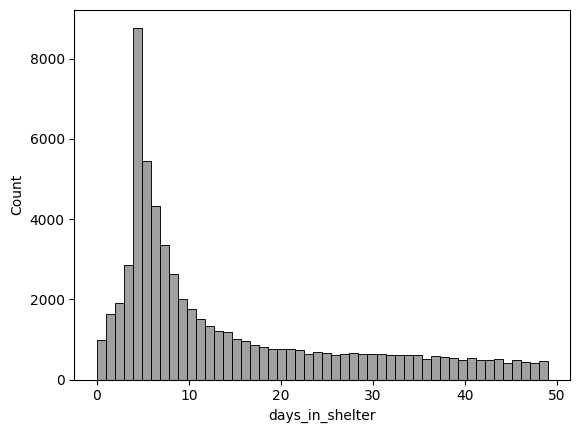

In [32]:
filtered_data = df[df.days_in_shelter < 50]# remove values that are greater than 50 to have a better visualization

plot = sns.histplot(filtered_data.days_in_shelter, color="grey", kde=False, bins=50)

plt.show()

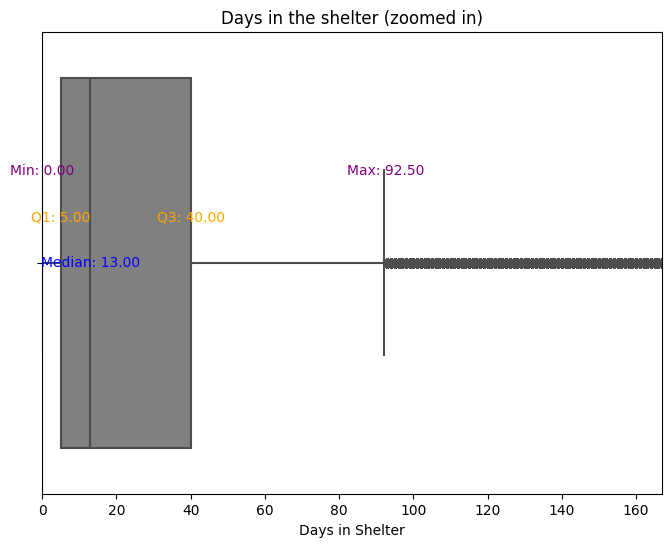

In [33]:
q1 = df['days_in_shelter'].quantile(0.25)
median = df['days_in_shelter'].median()
q3 = df['days_in_shelter'].quantile(0.75)
iqr = q3 - q1 
min_whisker = max(q1 - 1.5 * iqr, df['days_in_shelter'].min())
max_whisker = min(q3 + 1.5 * iqr, df['days_in_shelter'].max())

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df, x='days_in_shelter', color='grey')
 
plt.xlim(df['days_in_shelter'].quantile(0.01), df['days_in_shelter'].quantile(0.99)) # Zoom in to exclude outliers

plt.text(median, 0, f'Median: {median:.2f}', ha='center', va='center', fontsize=10, color='blue')
plt.text(q1, -0.1, f'Q1: {q1:.2f}', ha='center', va='center', fontsize=10, color='orange')
plt.text(q3, -0.1, f'Q3: {q3:.2f}', ha='center', va='center', fontsize=10, color='orange')
plt.text(min_whisker, -0.2, f'Min: {min_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
plt.text(max_whisker, -0.2, f'Max: {max_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
 
plt.title('Days in the shelter (zoomed in)')
plt.xlabel('Days in Shelter')
 
plt.show()


Creation of df just for EDA without outliers for the rest of categories.

In [34]:
df_eda =df[df.days_in_shelter < df.days_in_shelter.quantile(0.99)]

2. Type of animal, if they are castrated or not and their sex

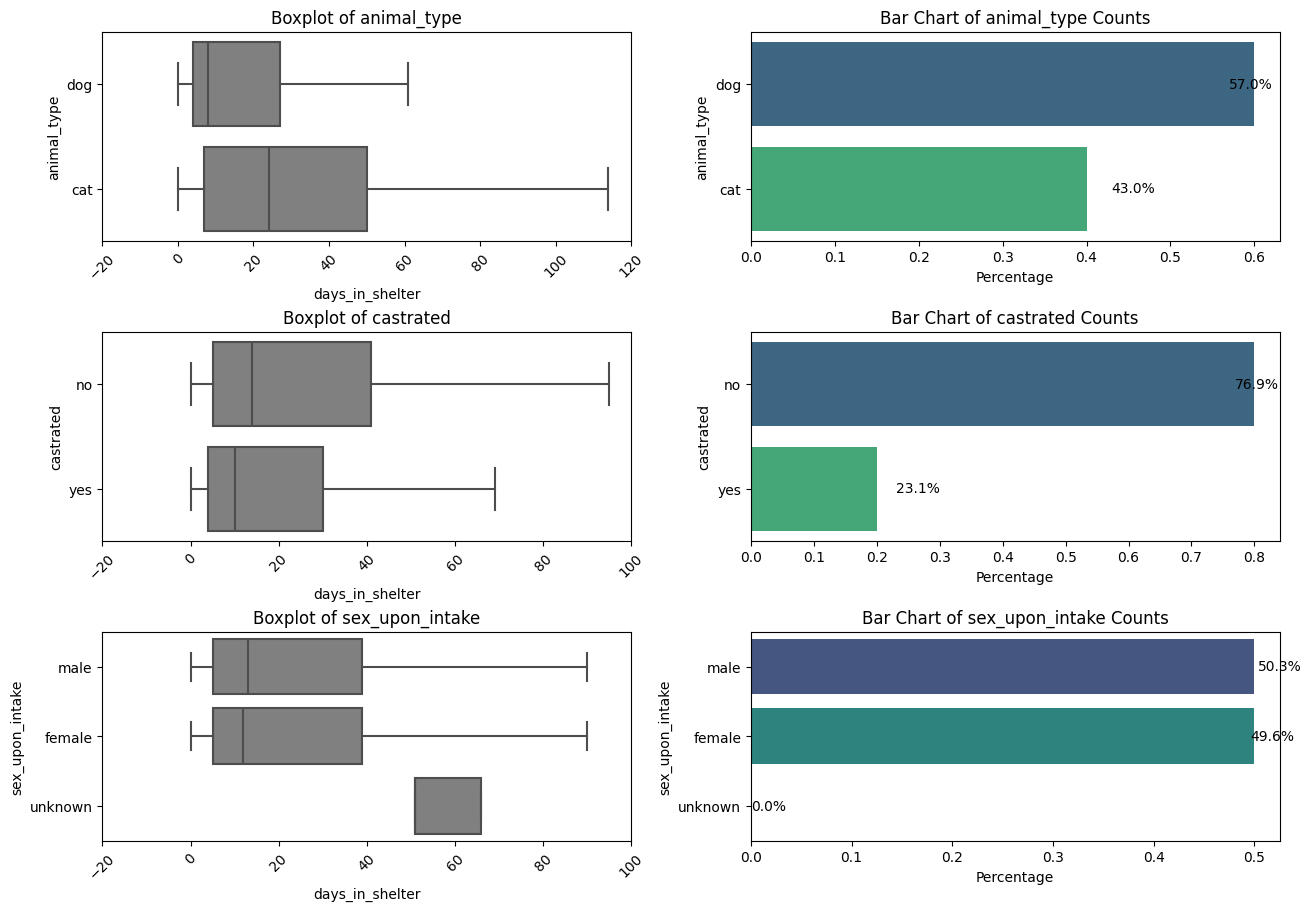

In [35]:
categories_graph = ['animal_type','castrated', 'sex_upon_intake' ]

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index
    
    
    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order 
        
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')

    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()


Observations:
* Species Distribution: Dogs constitute approximately 57% of intakes, and they tend to be adopted faster compared to cats.
*  Spay/Neuter Status: Only 23% of animals are spayed or neutered upon intake, yet they appear to have shorter adoption times.
*  Gender Distribution: The intake population is nearly evenly split between males and females, with no significant difference in adoption times between genders.

Action: Remove records where sex_upon_intake is marked as unknown to ensure data quality.

3. Intake condition and type

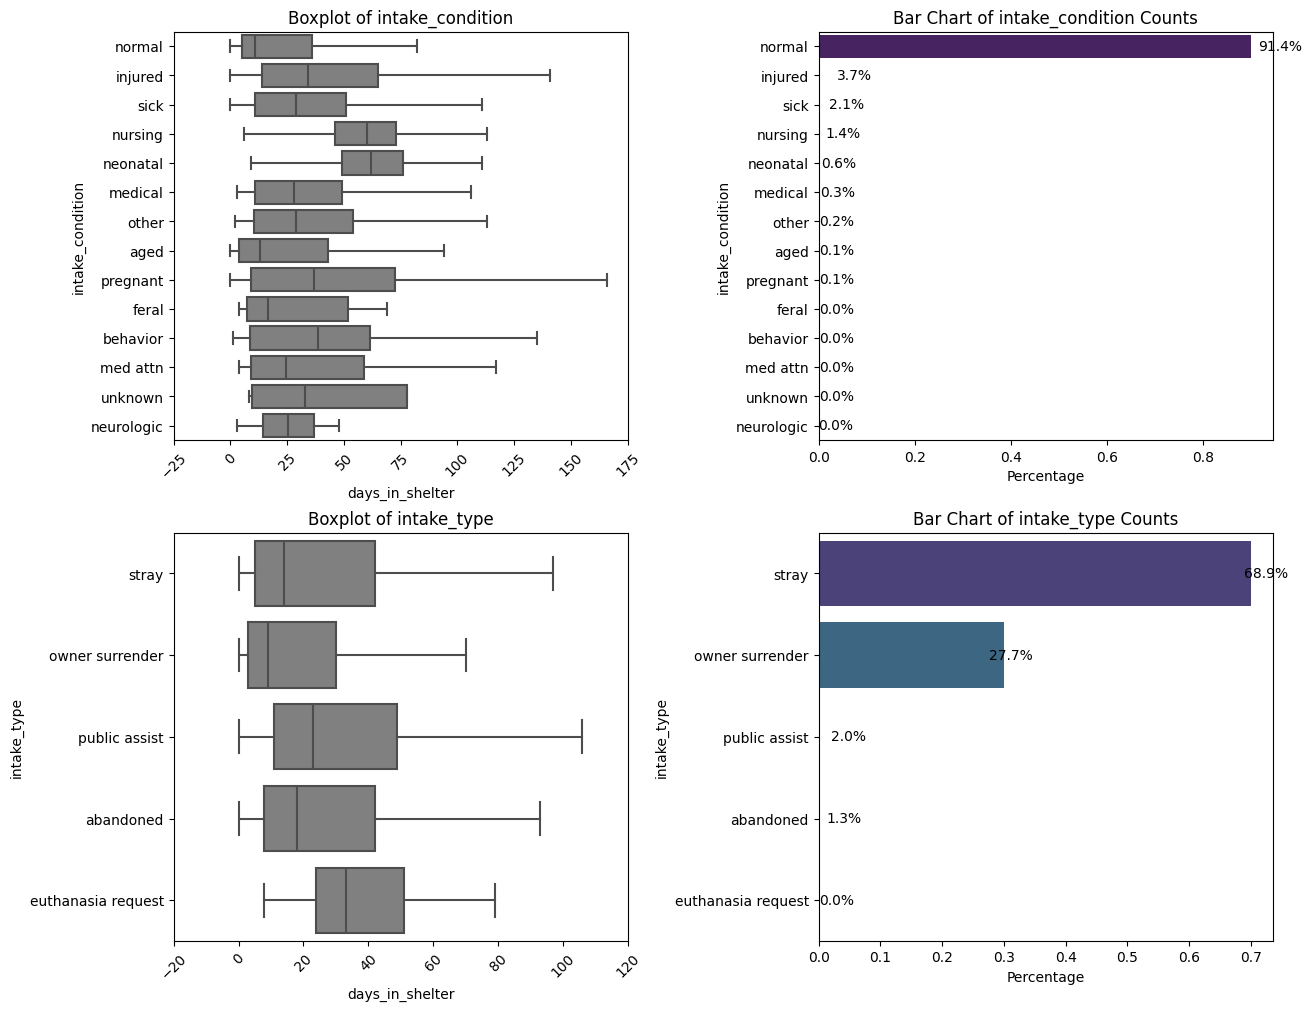

In [36]:
categories_graph = ['intake_condition',
                     'intake_type']

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 5), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index  

    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order 
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()



Observations
* Condition at Intake: Approximately 91% of animals enter the shelter in a "normal" condition. Analyzing the adoption times across different conditions reveals that some conditions have similar patterns. These conditions can be grouped together when their adoption times are comparable, simplifying the analysis. (Actions)
    * medical:med attn and medical
    * normal
    * sick-injured
    * other.
* Intake type: 69% are stray and 28% owner surrended. these 2 groups spend the least amount of time in the shelter, as shown by the narrow range in the boxplot. Action: I will group stray, owner surrended and Other

4. hair type, if they are mix or not, miniature or not and if they are domestic.

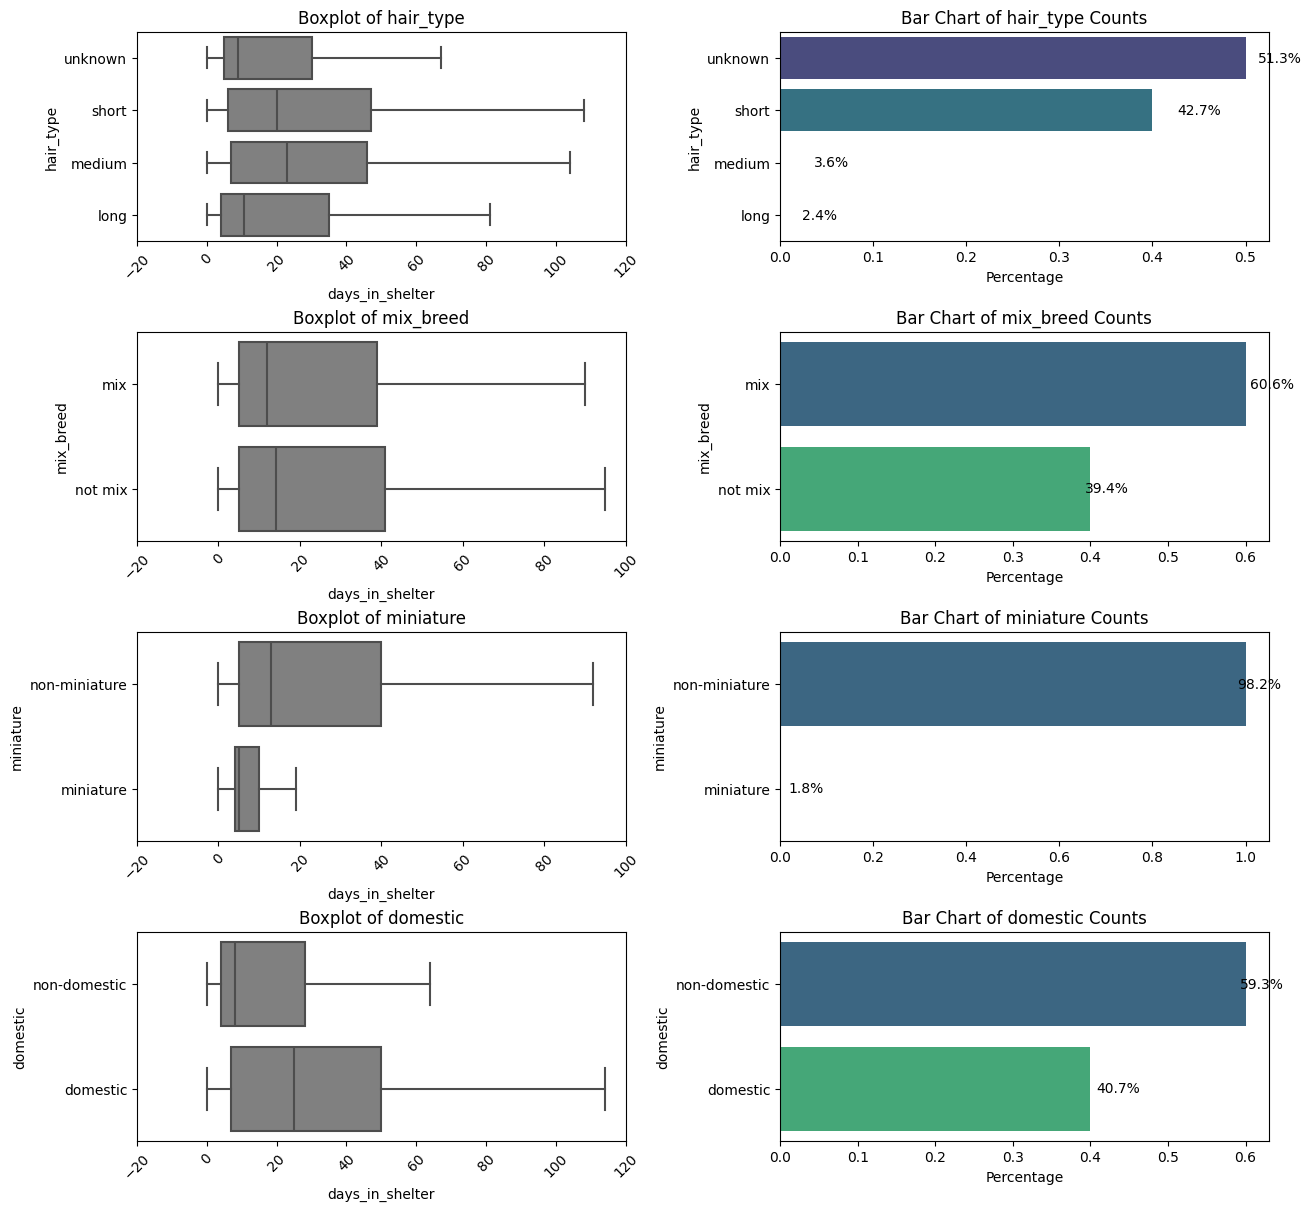

In [37]:
categories_graph = ['hair_type', 'mix_breed', 'miniature', 'domestic']

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index
    
    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order  
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    
    
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()


Observations:
* Hair Type: The majority of animals have an unknown hair type (51.6%), followed by short hair (42.4%). Medium and long hair types are relatively rare (3.6% and 2.4%, respectively). Adoption Time by Hair Type: Animals with medium-short hair appear to spend slightly more time in the shelter compared to other known categories.
* Mix Breed: Mixed breeds dominate (60.7%), while purebreds ("not mix") account for 39.3%. Mix breeds appear to spend slightly less in the shelter on average compared to non-mix breeds, but the difference is not very significant.
* Miniature Animals: Non-miniature animals overwhelmingly dominate (98.3%), while miniature animals make up a very small proportion (1.7%). Miniature animals tend to be adopted much faster, with consistently shorter times in the shelter.
* Domestic vs Non-Domestic: Non-domestic animals make up 59.4% of the population, while domestic animals account for 40.6%. Domestic animals appear to have longer shelter stays on average, while non-domestic animals exhibit a wider range and longer median time.

5. color and breed

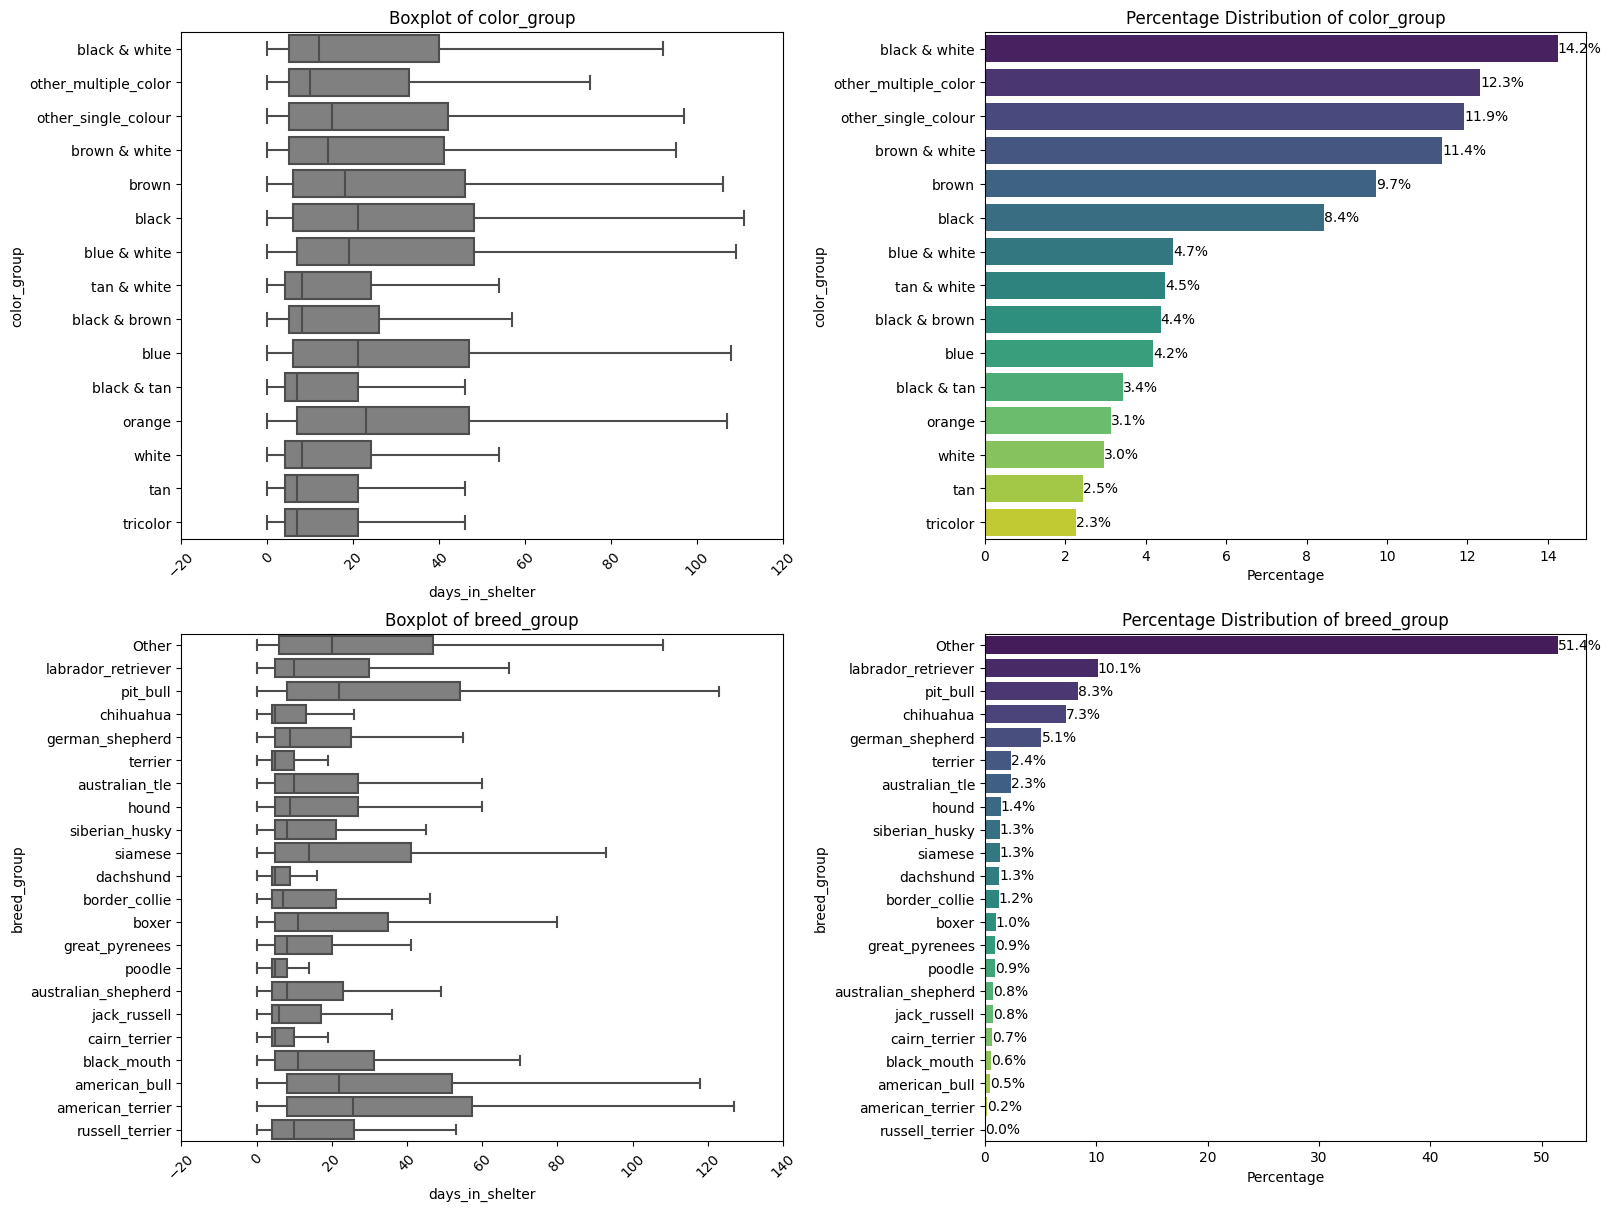

In [38]:
categories_graph = ['color_group', 'breed_group']

n_cols = 2 
n_rows = len(categories_graph) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6), constrained_layout=True)

# Flatten axes for iteration
axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True) * 100 
    category_order = value_counts.index 

    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values, y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Percentage Distribution of {column}')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)
    
    for j, percentage in enumerate(value_counts.values):
        axes[i, 1].text(
            percentage, j, f'{percentage:.1f}%',  
            ha='left', va='center'
        )

plt.show()


Color:   
the most common animals are black and white, accounting for 14.3% of the total, followed by brown and white at 11.4%, solid brown at 9.7%, and solid black at 8.4%.
Regarding adoption times, certain color groups such as tan and white, black and brown, black and tan, white, and tan tend to have shorter adoption times. These groups also show a smaller interquartile range (IQR), indicating less variability in their time to adoption. This suggests that these animals are adopted more consistently and efficiently compared to other color groups.

Breed:   
At first glance, we observe that breeds often labeled as "dangerous," such as Pit Bull, American Bull, and American Terrier, rusell terrier, tend to have significantly longer adoption times. Conversely, small dog breeds like Chihuahua, Terrier, Dachshund, Poodle, and Jack Russell are adopted much faster, with noticeably shorter shelter stays.

Action:Simplify the model by removing the detailed breed information and instead classify animals into two groups:
- Larger/“dangerous” breeds (e.g., Pit Bulls, American Bulls, etc.)
- Small or fast-adopting breeds (e.g., Chihuahuas, Dachshunds, etc.)
Additionally, include the most importat breeds: labrador, german sheperd, hound, siamese, sufficient for the model.

6. Age in months

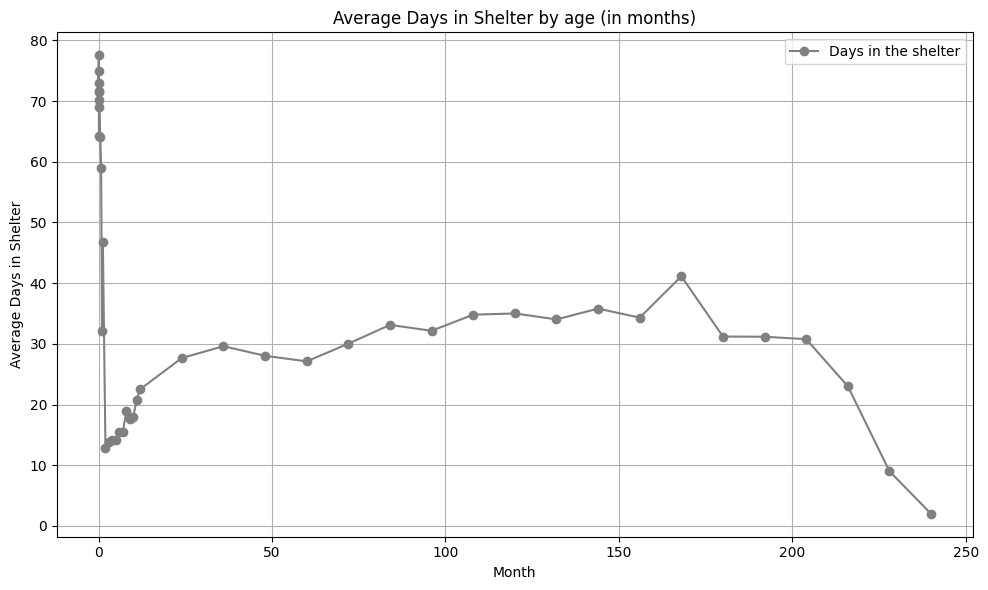

In [39]:
age_in_months = df_eda.groupby('age_in_months')['days_in_shelter'].mean().reset_index(name='avg_days_in')

plt.figure(figsize=(10, 6))
plt.plot(age_in_months['age_in_months'], age_in_months['avg_days_in'], color='grey', label='Days in the shelter', linestyle='-', marker='o') 
plt.title('Average Days in Shelter by age (in months)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

The chart shows the average number of days animals stay in the shelter based on their age in months. 
- Young Animals (0-10 months): Newborns spend a lot of time in the shelter (close to 80 days on average), but as they grow up to around 10 months old, their adoption time drops quickly. Younger animals tend to get adopted faster.
- Middle-Aged Animals (10-150 months): Between 10 months and about 150 months (roughly 12 years old), the average time in the shelter gradually goes up, hitting a peak around the 12-year mark. This suggests middle-aged animals might take longer to find homes.
- Senior Animals (150+ months): After around 150 months, the adoption time starts dropping again. It seems very senior animals might be prioritized for adoption or other care options.

7. Time series of animales entering the shelter and being addopted

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/533848525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/533848525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_out'] = pd.to_datetime({


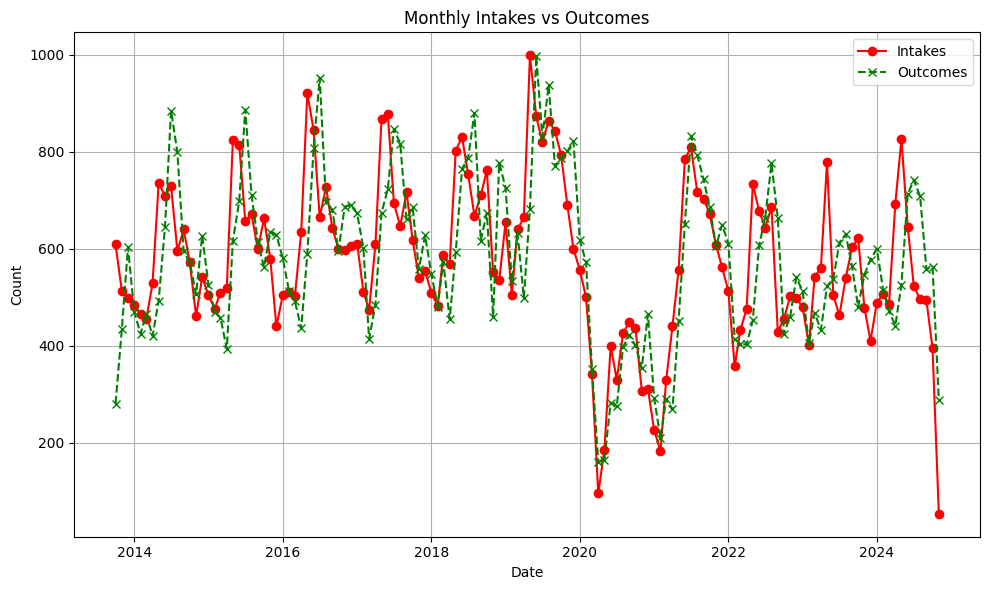

In [40]:
df_eda['month_in'] = pd.to_datetime({
    'year': df_eda['datetime_intake'].dt.year,
    'month': df_eda['datetime_intake'].dt.month,
    'day': 1
})


df_eda['month_out'] = pd.to_datetime({
    'year': df_eda['datetime_outcome'].dt.year,
    'month': df_eda['datetime_outcome'].dt.month,
    'day': 1
})

intake_data = df_eda.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_eda.groupby('month_out').size().reset_index(name='count_out')

merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0) 

merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'],color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color = 'g',label='Outcomes', linestyle='--', marker='x')

plt.title('Monthly Intakes vs Outcomes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


There appears to be a seasonal pattern in intakes, with noticeable fluctuations throughout the years. Additionally, there’s a sharp drop in intakes in 2020, likely linked to the COVID-19 pandemic.

8. Monthly effect, seasonal effect in deep

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/896402827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/896402827.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_out'] = pd.to_datetime({


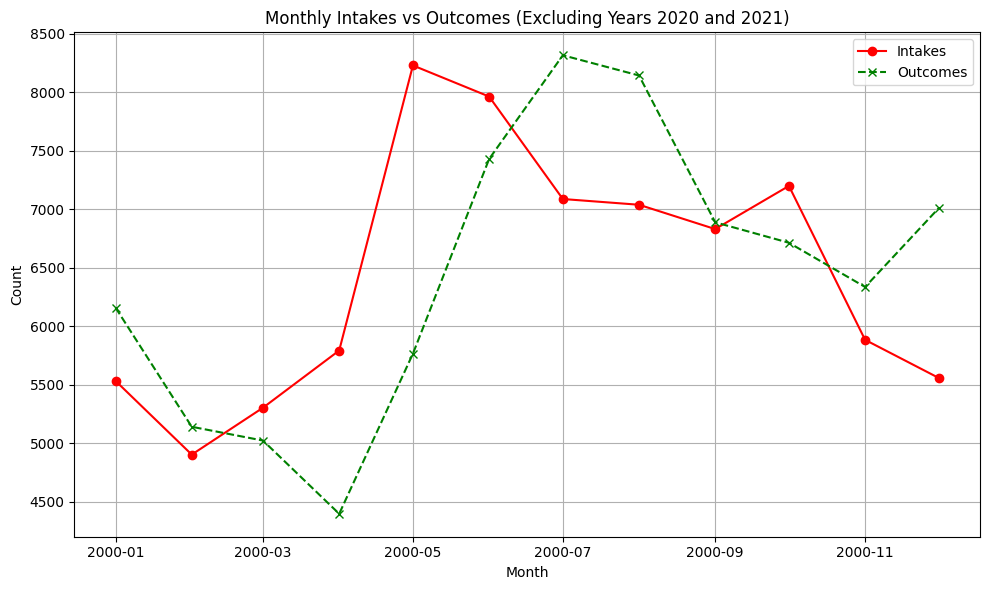

In [41]:
# Filter out years 2020 and 2021 from the DataFrame
df_graph = df_eda
[
    ~(df_eda['datetime_intake'].dt.year.isin([2020, 2021]) | 
      df_eda['datetime_outcome'].dt.year.isin([2020, 2021]))
]

df_graph['month_in'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_intake'].dt.month,
    'day': 1
})

df_graph['month_out'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_outcome'].dt.month,
    'day': 1
})
 
intake_data = df_graph.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_graph.groupby('month_out').size().reset_index(name='count_out')
 
merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0)
 
merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})
 
plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

plt.title('Monthly Intakes vs Outcomes (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There’s a clear seasonal effect where intakes peak in the middle of the year (spring/summer), while both intakes and outcomes decline toward the end of the year. 

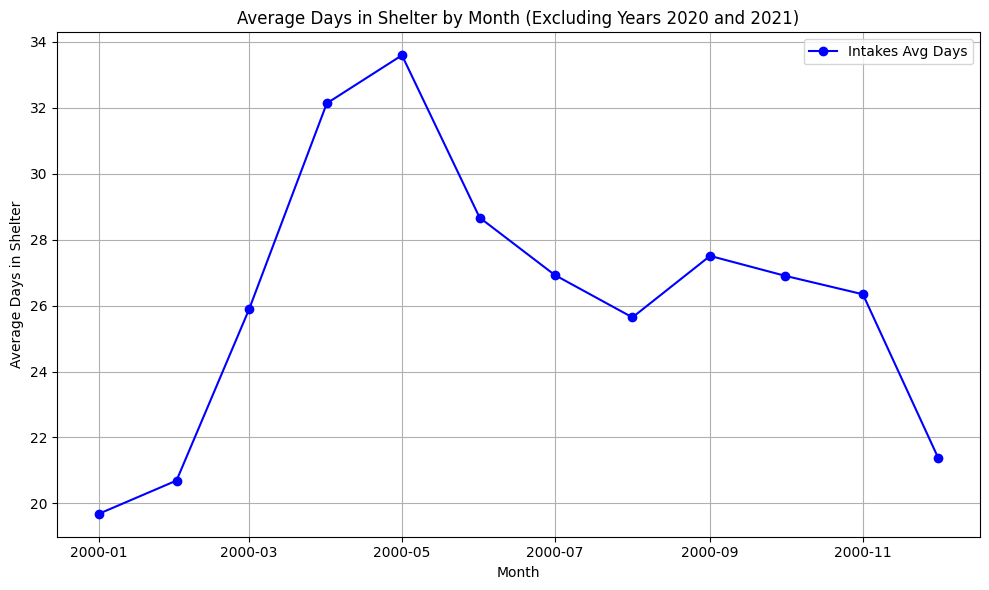

In [42]:
# Group by 'month_in' and calculate average days in shelter
intake_data = df_graph.groupby('month_in')['days_in_shelter'].mean().reset_index(name='avg_days_in')

plt.figure(figsize=(10, 6))
plt.plot(intake_data['month_in'], intake_data['avg_days_in'], color='b', label='Intakes Avg Days', linestyle='-', marker='o')

plt.title('Average Days in Shelter by Month (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

9. the day f the week when the animal entered has impact on their time in the shelter?

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/3770044732.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_10452/3770044732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()


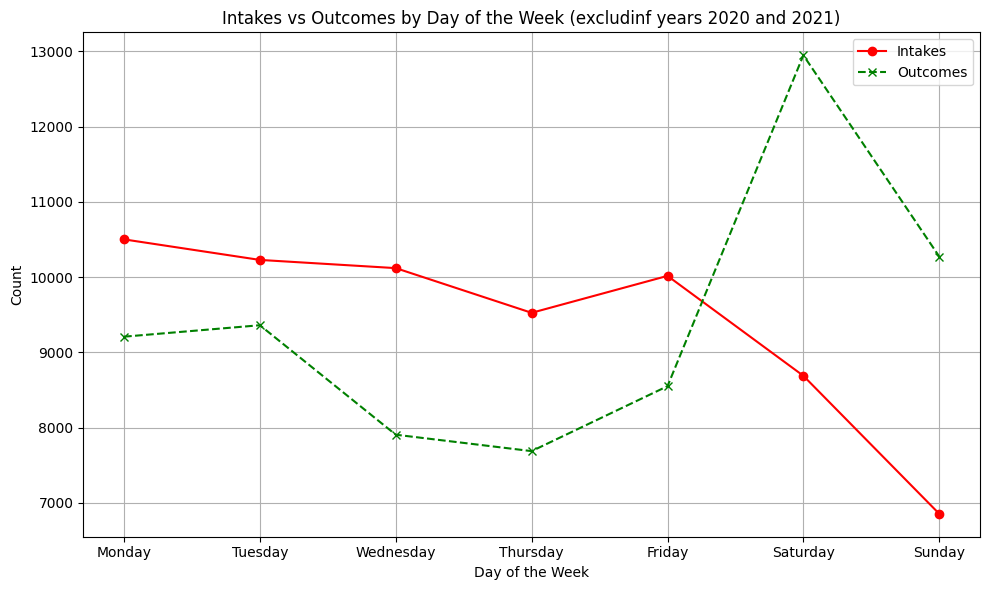

In [43]:
# Filter data for years 2020 and 2021
df_graph_week = df_eda[
   ~(df_eda['datetime_intake'].dt.year.isin([2020,2021]) | 
     df_eda['datetime_outcome'].dt.year.isin([2020,2021]))
]

df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()

intake_data = df_graph_week.groupby('day_of_week_in').size().reset_index(name='count_in')
outcome_data = df_graph_week.groupby('day_of_week_out').size().reset_index(name='count_out')

merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='day_of_week_in', 
                       right_on='day_of_week_out', 
                       how='outer').fillna(0)

merged_data = merged_data.rename(columns={
    'day_of_week_in': 'day_of_week_in',
    'day_of_week_out': 'day_of_week_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_data = merged_data.set_index('day_of_week_in').reindex(days_order).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(merged_data['day_of_week_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['day_of_week_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

plt.title('Intakes vs Outcomes by Day of the Week (excludinf years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


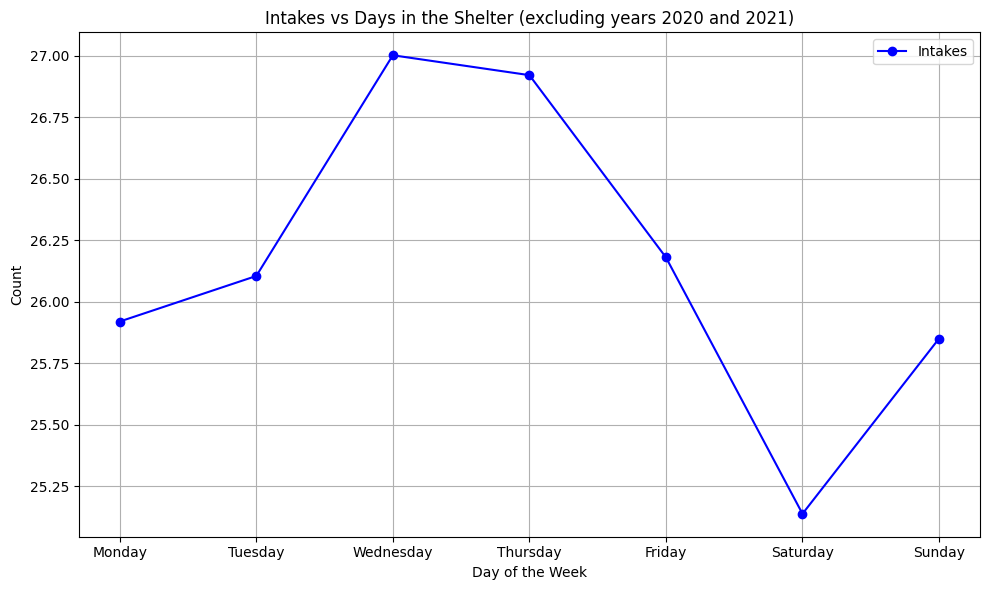

In [44]:
# Group by 'day_of_week_in' and 'day_of_week_out' to get counts
intake_data_week= df_graph_week.groupby('day_of_week_in')['days_in_shelter'].mean().reset_index(name='count_in')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intake_data_week = intake_data_week.set_index('day_of_week_in').reindex(days_order).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(intake_data_week['day_of_week_in'], intake_data_week['count_in'], color='b', label='Intakes', linestyle='-', marker='o')

plt.title('Intakes vs Days in the Shelter (excluding years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


* Saturday is critical for outcomes: The sharp spike in outcomes suggests shelters should maximize efforts for adoptions or releases on Saturdays when public interest may be highest.
* Sunday is a low-activity day: Both intakes and outcomes drop significantly on Sundays, likely reflecting limited operational activity.  
* Wednesday-Thursday challenges: Animals brought in on Wednesdays and Thurdays tend to stay in shelters longer, indicating potential inefficiencies or lower adoption rates midweek.

10. how many animals at the same time they are?

A new metric that might be interesting is the number of animals at the same time in the shelter comparing the datetime the animal enter vs how many other animals are at the same time 

In [45]:
# # Function to calculate the overlap count for a given row
# def count_overlapping(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter'] = df_eda.apply(lambda row: count_overlapping(row, df_eda), axis=1)


In [46]:
# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
# g = sns.lmplot(
#     x='days_in_shelter' , 
#     y= 'animals_in_shelter', 
#     data=df_eda,aspect=2,
#     scatter_kws={'alpha': 0.3, 'color': 'green'})
# g = (g.set_axis_labels( 'animals in the shelter', 'days in the shelter'))
# plt.title('title')
# plt.show()

The scatter plot shows a positive correlation between the number of days animals spend in the shelter and the number of animals when the animal enter in the shelter. More animals, less chances of being adopted.

In [47]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )

# # Check the binned data
# print(df_eda[['days_in_shelter', 'days_bin']].head())

# # Aggregate data: Calculate mean within each bin
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_mean=('animals_in_shelter', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )

# # Plot with Seaborn lineplot
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter (Mean)')
# plt.title('Animals in Shelter by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


is the same per type of animal.

11. Animals in the shelter of the same type: adding also the match by cat-dog

In [48]:
# # Function to calculate the overlap count for a given row, considering animal_type
# def count_overlapping_by_type(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df['animal_type'] == row['animal_type']) &           # Same animal type
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter_same_type'] = df_eda.apply(lambda row: count_overlapping_by_type(row, df_eda), axis=1)


In [49]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )
 
# print(df_eda[['days_in_shelter', 'days_bin']].head())
 
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_same_type_mean=('animals_in_shelter_same_type', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )
 
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_same_type_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter same type (Mean)')
# plt.title('Animals in Shelter same type by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


as there is no much change (and I also checked the model performance) I will use animals in the shelter without using from same type as takes more time to process the data - 4' vs 1'

-------

----


<h2 id="3">3. Model evaluation</h2>


<h3 id="31">3.1 Features selection pre-model</h3>


In [50]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group'],
      dtype='object')

creating is_male to use instead of sex_upon_intake

In [51]:
# in sex_upon_intake column, just add if is male or not to avoid having unknown values
df['is_male'] = df['sex_upon_intake'].apply(lambda x: 1 if x =='male' else 0)
df['is_male'].value_counts()    

is_male
1    39351
0    38763
Name: count, dtype: int64

group by intake_condition

In [52]:
# condition at intake: grouping medical (med attn and medical), normal, sick_injured and rest (other)
df['intake_condition_group'] = df['intake_condition'].apply(
    lambda x: 'normal' if 'normal' in x 
    else 'sick_injured' if 'sick' in x 
    else 'sick_injured' if 'injured' in x 
    else 'medical' if 'medical' in x 
    else 'medical' if 'med attn' in x  
    else 'nursing' if 'nursing' in x 
    else 'nursing' if 'neonatal' in x 
    else 'other')

group by intake type

In [53]:
# group intake type: stray, owner surrended and Other
df['intake_type_group'] = df['intake_type'].apply(
    lambda x: 'stray' if 'stray' in x 
    else 'owner surrender' if 'owner surrender' in x 
    else 'other'
)

In [54]:
df['breed_group'].value_counts()



breed_group
Other                  40113
labrador_retriever      7930
pit_bull                6652
chihuahua               5675
german_shepherd         3956
terrier                 1826
australian_tle          1820
hound                   1122
siamese                 1041
siberian_husky          1039
dachshund               1021
border_collie            966
boxer                    783
great_pyrenees           705
poodle                   702
australian_shepherd      609
jack_russell             592
cairn_terrier            523
black_mouth              454
american_bull            369
american_terrier         187
russell_terrier           29
Name: count, dtype: int64

In [55]:
# Simplify the model by removing the detailed breed information and instead classify animals into two groups:
# - Larger/“dangerous” breeds (e.g., Pit Bulls, American Bulls, etc.)
# - Small or fast-adopting breeds (e.g., Chihuahuas, Dachshunds, etc.)
# Additionally, include the most importat breeds: labrador, german sheperd, hound, siamese, sufficient for the model.

df['breed_group'] = df['breed_group'].apply(
    lambda x: 'larger_dangerous' if 'pit' in x 
    else 'larger_dangerous' if 'bull' in x 
    else 'larger_dangerous' if 'american_terrier' in x  
    else 'small_dog' if 'chihuahua' in x 
    else 'small_dog' if 'terrier' in x 
    else 'small_dog' if 'dachshund' in x 
    else 'small_dog' if 'poodle' in x 
    else 'small_dog' if 'jack_russell' in x 
    else 'small_dog' if 'russell_terrier' in x 
    else x)  

#### Change the features with just two options to 1-0 values 

In [56]:
# is_castrated
df['is_castrated'] = df['castrated'].apply(lambda x: 1 if x =='yes' else 0)
df['is_castrated'].value_counts()

is_castrated
0    59911
1    18203
Name: count, dtype: int64

In [57]:
# is_mix_breed
df['is_mix_breed'] = df['mix_breed'].apply(lambda x: 1 if x =='mix' else 0)
df['is_mix_breed'].value_counts()

is_mix_breed
1    47360
0    30754
Name: count, dtype: int64

In [58]:
# is_miniature
df['is_miniature'] = df['miniature'].apply(lambda x: 1 if x =='miniature' else 0)
df['is_miniature'].value_counts()


is_miniature
0    76746
1     1368
Name: count, dtype: int64

In [59]:
# is_domestic
df['is_domestic'] = df['domestic'].apply(lambda x: 1 if x =='domestic' else 0)
df['is_domestic'].value_counts()


is_domestic
0    46364
1    31750
Name: count, dtype: int64

In [60]:
# is dog
df['is_dog'] = df['animal_type'].apply(lambda x: 1 if x =='dog' else 0)
df['is_dog'].value_counts()

is_dog
1    44592
0    33522
Name: count, dtype: int64

#### New features after EDA:


Day of the week the animal entered into the shelter

In [61]:
# day of the week
df['day_of_week_in'] = df['datetime_intake'].dt.day_of_week
df['day_of_week_in'].value_counts()

day_of_week_in
0    12485
1    12392
2    12255
4    12021
3    11583
5     9704
6     7674
Name: count, dtype: int64

2. Month of intake

In [62]:
# month of the year
df['month_in'] = df['datetime_intake'].dt.month
df['month_in'].value_counts()

month_in
5     8305
6     8043
10    7260
7     7167
8     7120
9     6883
11    5934
4     5862
12    5611
1     5596
3     5367
2     4966
Name: count, dtype: int64

3. Number of other animals from the same type in the shelter when the animal entered

In [63]:
# Function to calculate the overlap count for a given row, considering animal_type
def count_overlapping_by_type(row, df):
    overlapping = df[
        (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
        (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
       ##(df['animal_type'] == row['animal_type']) &           # Same animal type
       ## (df['breed_group'] == row['breed_group']) &        # Same day of the week
        (df.index != row.name)  # Exclude the current record itself
    ]
    return len(overlapping)

# Apply the function to each row
df['animals_in_shelter'] = df.apply(lambda row: count_overlapping_by_type(row, df), axis=1)


In [64]:
df.head().T

,0,1,2,3,4
animal_id,a844350,a818975,a760053,a707375,a696408
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 east william cannon drive in austin (tx),braker lane and metric in travis (tx),8800 south first street in austin (tx),galilee court and damita jo dr in manor (tx),9705 thaxton in austin (tx)
intake_type,stray,stray,stray,stray,stray
intake_condition,normal,normal,normal,normal,normal
animal_type,cat,cat,dog,dog,dog
sex_upon_intake,female,male,male,female,female
datetime_outcome,2021-10-20 18:51:00,2020-07-23 15:54:00,2017-10-15 18:30:00,2015-11-28 17:31:00,2015-05-28 11:24:00
outcome_type,adoption,adoption,adoption,adoption,adoption
days_in_shelter,5,35,4,139,112


In [65]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group', 'is_male', 'intake_condition_group',
       'intake_type_group', 'is_castrated', 'is_mix_breed', 'is_miniature',
       'is_domestic', 'is_dog', 'day_of_week_in', 'month_in',
       'animals_in_shelter'],
      dtype='object')

In [66]:
numerical = [
    'age_in_months', 
    'month_in', 
    'animals_in_shelter',
    'day_of_week_in',
    'is_dog',
    'is_mix_breed', 
    'is_miniature', 
    'is_domestic',
    'is_castrated'] 
  
categorical = [    
    'intake_type_group',
    'intake_condition_group',  
    'is_male', 
    'hair_type',
   # 'day_of_week_in',
     'breed_group',     
     'color_group'
]
#   

In [67]:
# checckiing for missing values in columns inside numerical or categorical
missing_numerical = df[numerical].isnull().sum()
missing_categorical = df[categorical].isnull().sum()

print(f"Missing values in numerical columns:\n{missing_numerical[missing_numerical > 0]}\n")
print(f"Missing values in categorical columns:\n{missing_categorical[missing_categorical > 0]}")


Missing values in numerical columns:
Series([], dtype: int64)

Missing values in categorical columns:
Series([], dtype: int64)


------

<h3 id="32">3.2 Training models</h3>


For training the model we will use the whole dataset except the last 20% of the records ordered by datetime_intake that would be the test

Preparing the training dataset, validation and test dataset.

In [68]:
# for test: last 20% of the records based on the datetime_intake column
df.reset_index(drop=True, inplace=True)
df_test = df.sort_values('datetime_intake').tail(int(len(df) * 0.2))
print('test df from: ',df_test['datetime_intake'].min(), 'test df to: ' ,df_test['datetime_intake'].max())

# for train: the rest of the records that I will divide into train and validation sets
df_full_train = df.drop(df_test.index).reset_index(drop=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.20, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.days_in_shelter.values
y_train = df_train.days_in_shelter.values
y_val = df_val.days_in_shelter.values
y_test = df_test.days_in_shelter.values

del df_full_train['days_in_shelter']
del df_train['days_in_shelter']
del df_val['days_in_shelter']
del df_test['days_in_shelter']

test df from:  2022-06-22 12:20:00 test df to:  2024-11-10 13:10:00


In [69]:
# remove the outcome columns from the dataset train

In [70]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [71]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)  # Use transform, not fit_transform

In [72]:
full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)


In [73]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [74]:
print(dv.feature_names_)

['age_in_months', 'animals_in_shelter', 'breed_group=Other', 'breed_group=australian_shepherd', 'breed_group=australian_tle', 'breed_group=black_mouth', 'breed_group=border_collie', 'breed_group=boxer', 'breed_group=german_shepherd', 'breed_group=great_pyrenees', 'breed_group=hound', 'breed_group=labrador_retriever', 'breed_group=larger_dangerous', 'breed_group=siamese', 'breed_group=siberian_husky', 'breed_group=small_dog', 'color_group=black', 'color_group=black & brown', 'color_group=black & tan', 'color_group=black & white', 'color_group=blue', 'color_group=blue & white', 'color_group=brown', 'color_group=brown & white', 'color_group=orange', 'color_group=other_multiple_color', 'color_group=other_single_colour', 'color_group=tan', 'color_group=tan & white', 'color_group=tricolor', 'color_group=white', 'day_of_week_in', 'hair_type=long', 'hair_type=medium', 'hair_type=short', 'hair_type=unknown', 'intake_condition_group=medical', 'intake_condition_group=normal', 'intake_condition_gr

-------

<h4 id="33">3.2.1 Linear regression</h4>

In [75]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
y_val_pred = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 9.49
RMSE: 13.85
Mean Squared Error (MSE): 191.74
R² Score: 0.84


In [76]:
feature_importance = pd.DataFrame({
    'Feature': dv.feature_names_,
    'Coefficient': lr_model.coef_ 
}).sort_values(by='Coefficient', ascending=False)
 
feature_importance['Coefficient'] = feature_importance['Coefficient'].round(3)
print('positive top10 features: ',feature_importance.head(10))
print('negative top10 features: ',feature_importance.tail(10))


positive top10 features:                                  Feature  Coefficient
36       intake_condition_group=medical        3.801
12         breed_group=larger_dangerous        3.469
41              intake_type_group=other        3.010
7                     breed_group=boxer        1.653
40  intake_condition_group=sick_injured        1.596
38       intake_condition_group=nursing        1.478
4            breed_group=australian_tle        1.149
11       breed_group=labrador_retriever        0.775
5               breed_group=black_mouth        0.706
34                      hair_type=short        0.522
negative top10 features:                                Feature  Coefficient
14         breed_group=siberian_husky       -0.734
30                  color_group=white       -0.767
13                breed_group=siamese       -0.942
46                        is_domestic       -1.074
42  intake_type_group=owner surrender       -1.074
9          breed_group=great_pyrenees       -1.559
43      

cross-validation 

In [77]:
from sklearn.model_selection import cross_val_score
 
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rmse_scores = (-scores)**0.5
 
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
 
sem = rmse_std / np.sqrt(len(rmse_scores))

# 95% confidence interval
z = 1.96  
lower_bound = rmse_mean - z * sem
upper_bound = rmse_mean + z * sem

# Print results
print(f"Cross-Validated RMSE: {rmse_mean:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")


Cross-Validated RMSE: 13.61
95% Confidence Interval: [13.52, 13.70]


In [78]:
# check the model on the test set
lr_model = LinearRegression()
lr_model.fit(X_full_train, y_full_train)
y_test_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 8.91
Mean Squared Error (MSE): 147.98
Root Mean Squared Error (RMSE): 12.16
R² Score: 0.88


------

<h4 id="322">3.2.2 Random Forest</h4>

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [89]:

# Define a function to calculate RMSE using sklearn's mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
    return np.sqrt(mse)  # Return RMSE

# Example usage
y_pred = rf.predict(X_val)  # Get predictions from your model
rmse_value = root_mean_squared_error(y_val, y_pred)  # Calculate RMSE
print(f"RMSE: {rmse_value}")


RMSE: 10.408724112114918


In [90]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.408724112114918

In [93]:
%matplotlib inline

In [94]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [95]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


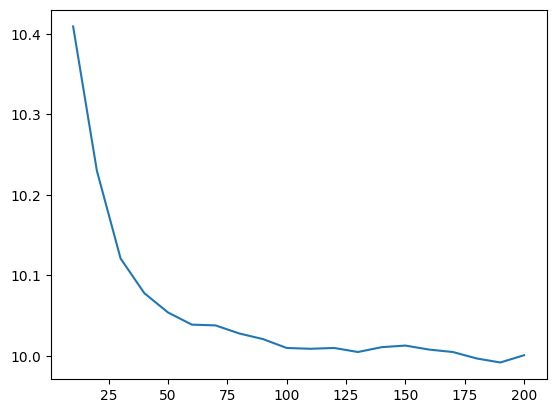

In [96]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

In [97]:
scores = []

for d in tqdm([10, 15, 20, 25, 35,40, 45, 55]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [03:21<00:00, 25.22s/it]


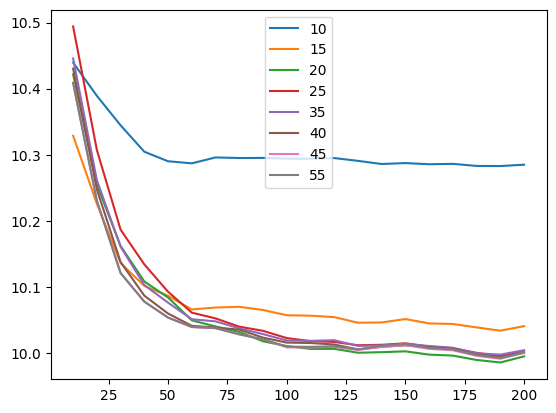

In [98]:
for d in [10, 15, 20, 25, 35, 40,45, 55]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [99]:
rf = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=125, n_jobs=-1, random_state=1)

In [100]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.004557600337375

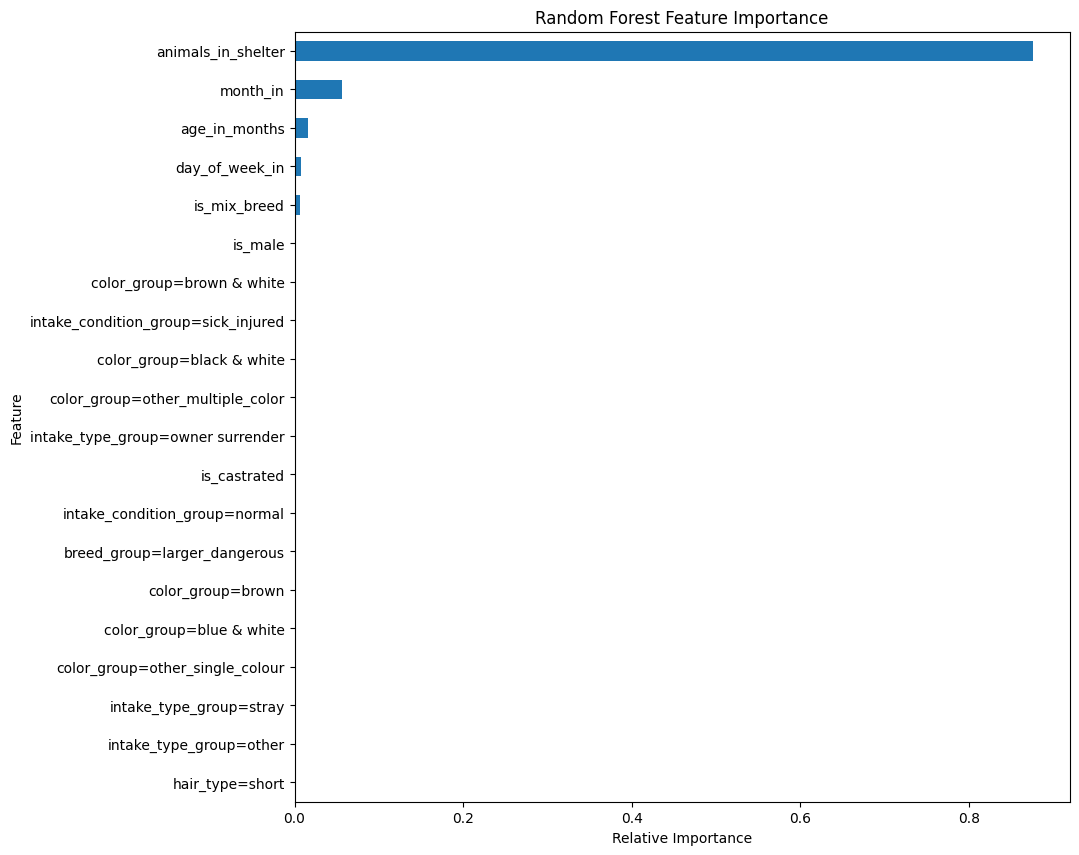

In [101]:
# Create a DataFrame for feature importance
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
 
df_importances['relative_importance'] = df_importances['importance'] / df_importances['importance'].sum()
 
df_importances = df_importances.sort_values(by='relative_importance', ascending=True)
 
df_importances.tail(20).plot(kind='barh', x='feature', y='relative_importance', legend=False, figsize=(10, 10))
plt.title('Random Forest Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()


doing once the grid search to verify our results before

In [102]:
# # using grid search to find the best hyperparameters
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [75, 100, 125, 150, 200],
#     'max_depth': [10, 15, 20, 25, 35,40, 45, 55],
# }

# rf = RandomForestRegressor(random_state=1, n_jobs=-1)

# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f"Best parameters: {grid_search.best_params_}")

In [103]:
# using the full train set to train the model and then evaluate it on the test set
rf = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_full_train, y_full_train)
y_test_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 11.01


---

#### XGboost

In [104]:
import io
from contextlib import redirect_stdout
import xgboost as xgb
 
features = list(dv.get_feature_names_out()) 

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# Watchlist for monitoring training and validation
watchlist = [(dtrain, 'train'), (dval, 'val')]



In [105]:
# XGBoost parameters for regression
xgb_params = {
    'eta': 0.03,                 # Learning rate: default 0.3
    'max_depth': 6,              # Maximum depth of trees: default 6
    'min_child_weight': 1,       # Minimum weight sum of child nodes
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': -1,                # Number of threads
    'seed': 1,                   # Random seed
    'verbosity': 1,              # to display warnings
    'eval_metric': 'rmse'        # Metric for monitoring performance
}



rmse by boosting rounds

In [106]:
# Redirect stdout to capture output
f = io.StringIO()
with redirect_stdout(f):
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=200,    
        verbose_eval=5,       
        evals=watchlist           
    )

captured_output = f.getvalue()
print("Captured Output:\n")
print(captured_output)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

evals_result = {}

# Train again to capture results for plotting
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=5,
    evals_result=evals_result
)

Captured Output:

[0]	train-rmse:42.43883	val-rmse:42.08878
[5]	train-rmse:36.90896	val-rmse:36.63908
[10]	train-rmse:32.20780	val-rmse:32.02730
[15]	train-rmse:28.22912	val-rmse:28.12584
[20]	train-rmse:24.87362	val-rmse:24.84252
[25]	train-rmse:22.05710	val-rmse:22.09618
[30]	train-rmse:19.70049	val-rmse:19.80684
[35]	train-rmse:17.74935	val-rmse:17.91631
[40]	train-rmse:16.14259	val-rmse:16.36618
[45]	train-rmse:14.82850	val-rmse:15.10451
[50]	train-rmse:13.76592	val-rmse:14.08287
[55]	train-rmse:12.90830	val-rmse:13.27108
[60]	train-rmse:12.22588	val-rmse:12.62611
[65]	train-rmse:11.68437	val-rmse:12.11556
[70]	train-rmse:11.25435	val-rmse:11.71142
[75]	train-rmse:10.91445	val-rmse:11.40017
[80]	train-rmse:10.64261	val-rmse:11.15214
[85]	train-rmse:10.42194	val-rmse:10.95869
[90]	train-rmse:10.24682	val-rmse:10.80790
[95]	train-rmse:10.11090	val-rmse:10.69241
[100]	train-rmse:9.99762	val-rmse:10.59904
[105]	train-rmse:9.90595	val-rmse:10.52263
[110]	train-rmse:9.82634	val-rmse:10.4

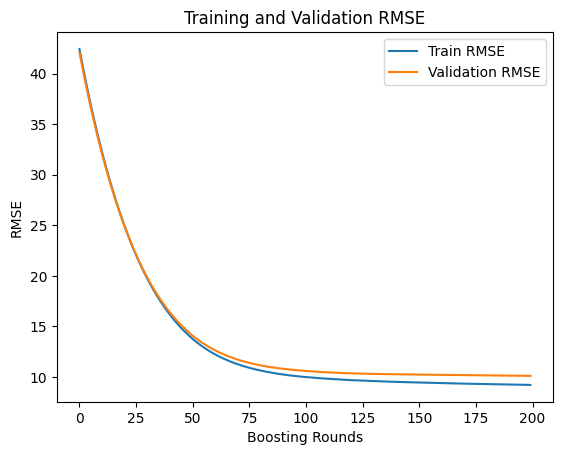

In [107]:
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['val']['rmse']

plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()


- Both the training and validation RMSE values drop steeply in the first 20–30 boosting rounds. This indicates that the model is quickly learning the main patterns in the data during the early stages of training.  
- After around 50–100 boosting rounds, the RMSE for both training and validation stabilizes, showing diminishing returns for additional rounds. This indicates the model has reached a near-optimal level of performance.  
- The training and validation RMSE curves are very close to each other throughout the boosting process -> The model is not overfitting significantly. I will use the regularization parameters (alpha, or eta) and early stopping as they are useful to prevent overfitting.

In [108]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=watchlist,
    verbose_eval=5,
    early_stopping_rounds=5 # Stop if no improvement for 10 rounds
) 

[0]	train-rmse:42.43883	val-rmse:42.08878
[5]	train-rmse:36.90896	val-rmse:36.63908
[10]	train-rmse:32.20780	val-rmse:32.02730
[15]	train-rmse:28.22912	val-rmse:28.12584
[20]	train-rmse:24.87362	val-rmse:24.84252
[25]	train-rmse:22.05710	val-rmse:22.09618
[30]	train-rmse:19.70049	val-rmse:19.80684
[35]	train-rmse:17.74935	val-rmse:17.91631
[40]	train-rmse:16.14259	val-rmse:16.36618
[45]	train-rmse:14.82850	val-rmse:15.10451
[50]	train-rmse:13.76592	val-rmse:14.08287
[55]	train-rmse:12.90830	val-rmse:13.27108
[60]	train-rmse:12.22588	val-rmse:12.62611
[65]	train-rmse:11.68437	val-rmse:12.11556
[70]	train-rmse:11.25435	val-rmse:11.71142
[75]	train-rmse:10.91445	val-rmse:11.40017
[80]	train-rmse:10.64261	val-rmse:11.15214
[85]	train-rmse:10.42194	val-rmse:10.95869
[90]	train-rmse:10.24682	val-rmse:10.80790
[95]	train-rmse:10.11090	val-rmse:10.69241
[100]	train-rmse:9.99762	val-rmse:10.59904
[105]	train-rmse:9.90595	val-rmse:10.52263
[110]	train-rmse:9.82634	val-rmse:10.45904
[115]	train-r

In [109]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 10.119153871299288


Hyperparameter tunning

ETA

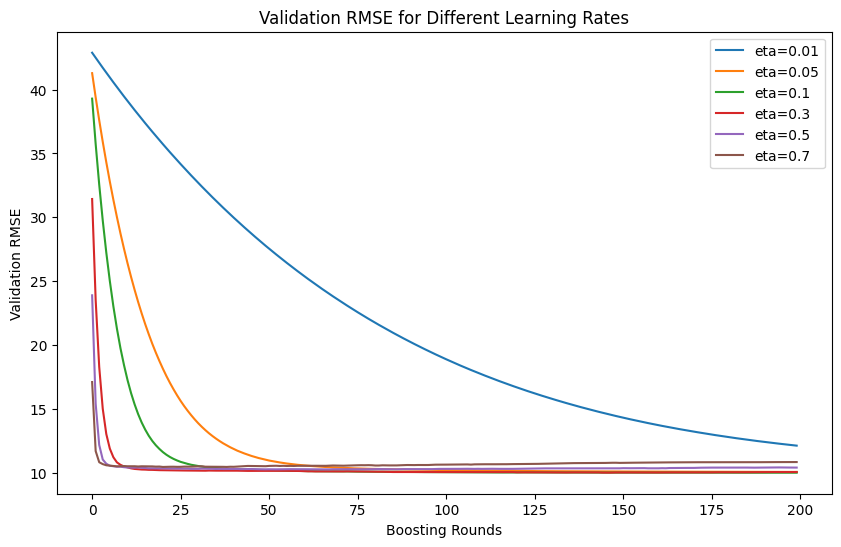

Final RMSE for eta=0.01: 12.119526025323067
Final RMSE for eta=0.05: 10.060004879682397
Final RMSE for eta=0.1: 10.000367052077483
Final RMSE for eta=0.3: 10.05378815581505
Final RMSE for eta=0.5: 10.40061085131863
Final RMSE for eta=0.7: 10.834408454229594


In [110]:

def train_xgboost(eta, num_boost_round, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                
        'max_depth': 6,             
        'min_child_weight': 1,       
        'objective': 'reg:squarederror',  
        'nthread': -1,                 
        'seed': 1,                
        'verbosity': 1,              
        'eval_metric': 'rmse'        
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model
 
results = {}
for eta in [0.01,0.05,0.1, 0.3, 0.5, 0.7]:
    evals_result, model = train_xgboost(eta=eta, num_boost_round=200)
    results[eta] = evals_result


plt.figure(figsize=(10, 6))

for eta, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'eta={eta}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different Learning Rates')
plt.legend()
plt.show()


for eta, evals_result in results.items():
    print(f"Final RMSE for eta={eta}: {evals_result['val']['rmse'][-1]}")


This chart shows the validation RMSE for different learning rates (eta) over boosting rounds in XGBoost. Here's what you can infer from this plot:

The green (eta = 0.1) and red (eta = 0.3) lines reach low RMSE values quickly and stabilize effectively.
These learning rates strike a good balance between speed of convergence and generalization, making them ideal in many cases.

The orange (eta = 0.7) and purple (eta = 0.5) lines converge very quickly in the first 10–25 boosting rounds.
However, after rapid convergence, the RMSE plateaus and doesn’t improve much. This indicates that high learning rates lead to fast learning but may fail to fully optimize the model.
The risk of overfitting or poor generalization increases with higher eta.

Lower eta (e.g., 0.01) achieves a slightly lower RMSE over time but takes significantly longer (many boosting rounds).


max_depth

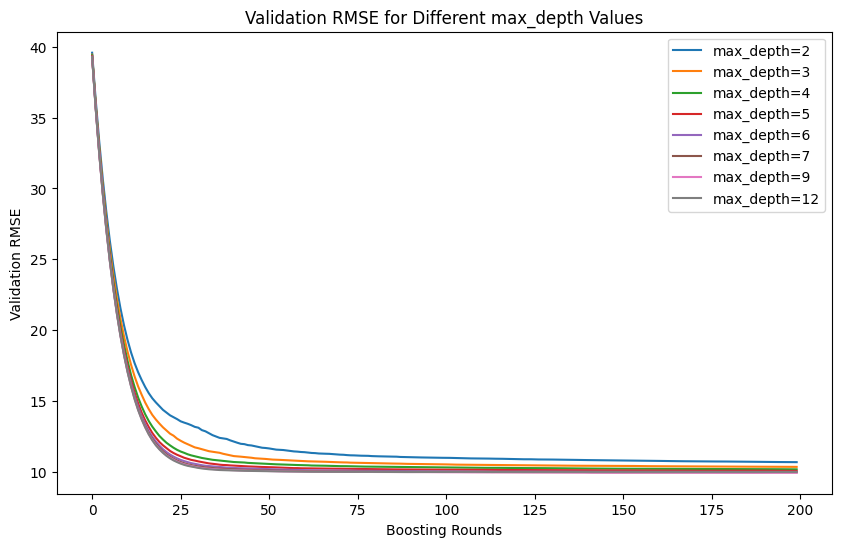

Final RMSE for max_depth=2: 10.690363567585926
Final RMSE for max_depth=3: 10.357284753990946
Final RMSE for max_depth=4: 10.183535379203757
Final RMSE for max_depth=5: 10.071301933214334
Final RMSE for max_depth=6: 10.000367052077483
Final RMSE for max_depth=7: 9.96778142075227
Final RMSE for max_depth=9: 9.944881844656141
Final RMSE for max_depth=12: 10.000842502155061


In [111]:
# Define a function to train models with varying max_depth
def train_xgboost_with_max_depth(max_depth, num_boost_round, eta=0.1, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,              
        'max_depth': max_depth,      
        'min_child_weight': 1,       
        'objective': 'reg:squarederror',         
         'nthread': -1,              
        'seed': 1,                   
        'verbosity': 1,             
        'eval_metric': 'rmse'}
                        

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model


max_depth_values = [2, 3, 4,5, 6, 7, 9, 12]
results = {}

for max_depth in max_depth_values:
    evals_result, model = train_xgboost_with_max_depth(max_depth=max_depth, num_boost_round=200)
    results[max_depth] = evals_result


plt.figure(figsize=(10, 6))

for max_depth, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'max_depth={max_depth}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different max_depth Values')
plt.legend()
plt.show()


for max_depth, evals_result in results.items():
    print(f"Final RMSE for max_depth={max_depth}: {evals_result['val']['rmse'][-1]}")


Choose max_depth=6 as is a good balance between performance and computational efficiency. 
Values like max_depth=9 or 12 add complexity without significant performance gains and may lead to overfitting

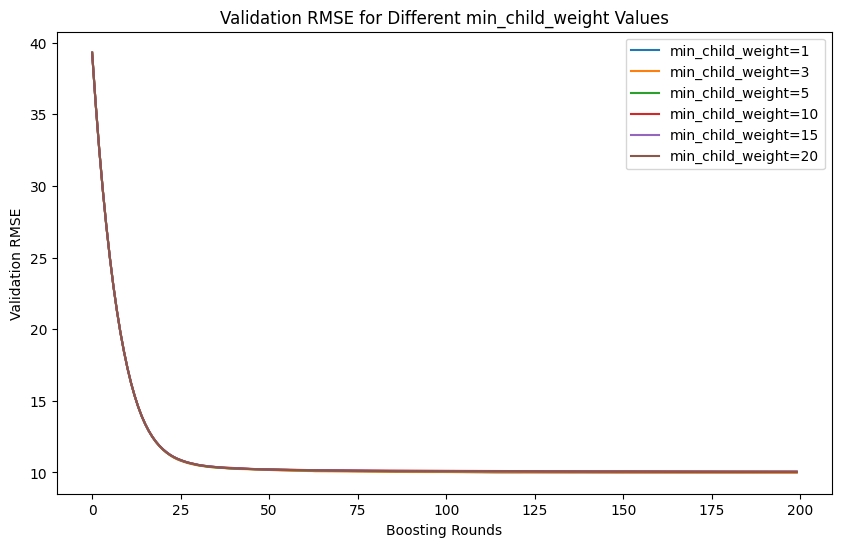

Final RMSE for min_child_weight=1: 10.000367052077483
Final RMSE for min_child_weight=3: 9.983938805642063
Final RMSE for min_child_weight=5: 10.04589317570942
Final RMSE for min_child_weight=10: 10.062433599082667
Final RMSE for min_child_weight=15: 10.059312924071124
Final RMSE for min_child_weight=20: 10.03861632511588


In [112]:
# Define a function to train models with varying min_child_weight
def train_xgboost_with_min_child_weight(min_child_weight, num_boost_round, eta=0.1, max_depth=6, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                
        'max_depth': max_depth,    
        'min_child_weight': min_child_weight,  
        'objective': 'reg:squarederror',          
        'nthread': -1,              
        'seed': 1,                 
        'verbosity': 1,             
        'eval_metric': 'rmse'       
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False, 
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

min_child_weight_values = [1, 3, 5, 10, 15, 20]
results = {}

for min_child_weight in min_child_weight_values:
    evals_result, model = train_xgboost_with_min_child_weight(min_child_weight=min_child_weight, num_boost_round=200)
    results[min_child_weight] = evals_result


plt.figure(figsize=(10, 6))

for min_child_weight, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'min_child_weight={min_child_weight}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different min_child_weight Values')
plt.legend()
plt.show()


for min_child_weight, evals_result in results.items():
    print(f"Final RMSE for min_child_weight={min_child_weight}: {evals_result['val']['rmse'][-1]}")


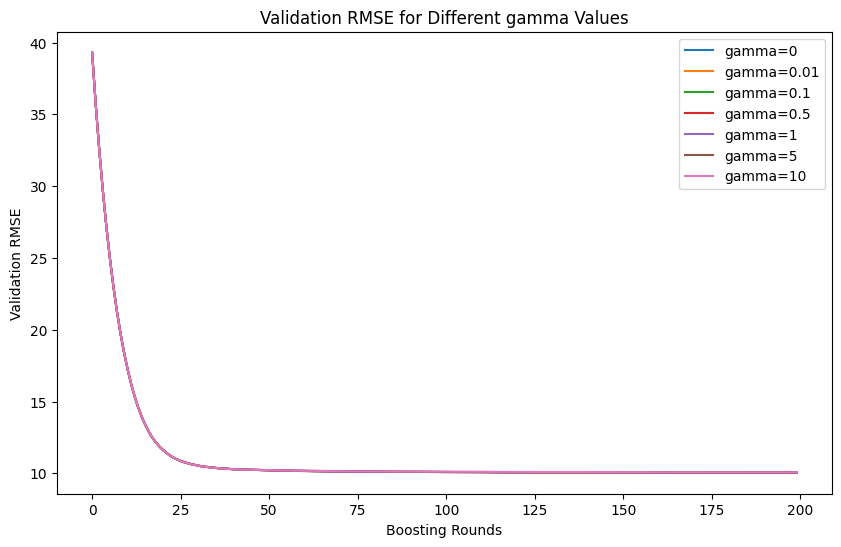

Final RMSE for gamma=0: 10.059312924071124
Final RMSE for gamma=0.01: 10.059312924071124
Final RMSE for gamma=0.1: 10.059312924071124
Final RMSE for gamma=0.5: 10.04760822856825
Final RMSE for gamma=1: 10.04760822856825
Final RMSE for gamma=5: 10.042690240555729
Final RMSE for gamma=10: 10.068976929249432


In [113]:
# Define a function to train models with varying gamma
def train_xgboost_with_gamma(gamma, num_boost_round, eta=0.1, max_depth=6,  min_child_weight=15,  early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                  
        'max_depth': max_depth,        
        'gamma': gamma,        
        'min_child_weight': min_child_weight,  
        'objective': 'reg:squarederror',
        'nthread': -1,              
        'seed': 1,                   
        'verbosity': 1,                 
        'eval_metric': 'rmse'           
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

gamma_values = [0, 0.01, 0.1, 0.5, 1, 5, 10]
results_gamma = {}

for gamma in gamma_values:
    evals_result, model = train_xgboost_with_gamma(gamma=gamma, num_boost_round=200)
    results_gamma[gamma] = evals_result

plt.figure(figsize=(10, 6))

for gamma, evals_result in results_gamma.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'gamma={gamma}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different gamma Values')
plt.legend()
plt.show()


for gamma, evals_result in results_gamma.items():
    print(f"Final RMSE for gamma={gamma}: {evals_result['val']['rmse'][-1]}")


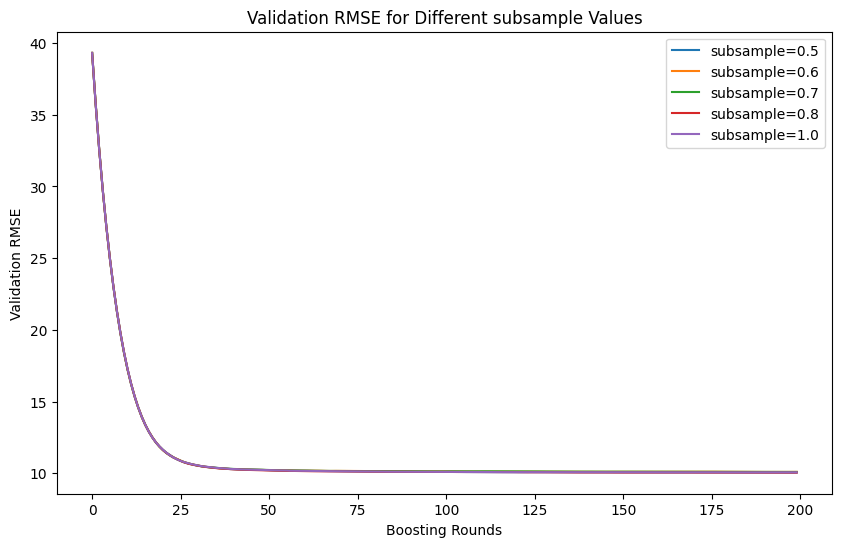

Final RMSE for subsample=0.5: 10.05383966053713
Final RMSE for subsample=0.6: 10.091704537557892
Final RMSE for subsample=0.7: 10.087036751476179
Final RMSE for subsample=0.8: 10.036234369395217
Final RMSE for subsample=1.0: 10.059312924071124


In [114]:
# Define a function to train models with varying subsample
def train_xgboost_with_subsample(subsample, num_boost_round,gamma = 0.1, eta=0.1, max_depth=6,  min_child_weight=15, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                     
        'max_depth': max_depth,          
        'gamma': gamma,                
        'subsample': subsample,      
        'min_child_weight': min_child_weight, 
        'objective': 'reg:squarederror', 
        'nthread': -1,                      
        'seed': 1,                    
        'verbosity': 1,                 
        'eval_metric': 'rmse'            
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model


subsample_values = [0.5, 0.6, 0.7, 0.8, 1.0]
results_subsample = {}

for subsample in subsample_values:
    evals_result, model = train_xgboost_with_subsample(subsample=subsample, num_boost_round=200)
    results_subsample[subsample] = evals_result


plt.figure(figsize=(10, 6))

for subsample, evals_result in results_subsample.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'subsample={subsample}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different subsample Values')
plt.legend()
plt.show() 

for subsample, evals_result in results_subsample.items():
    print(f"Final RMSE for subsample={subsample}: {evals_result['val']['rmse'][-1]}")


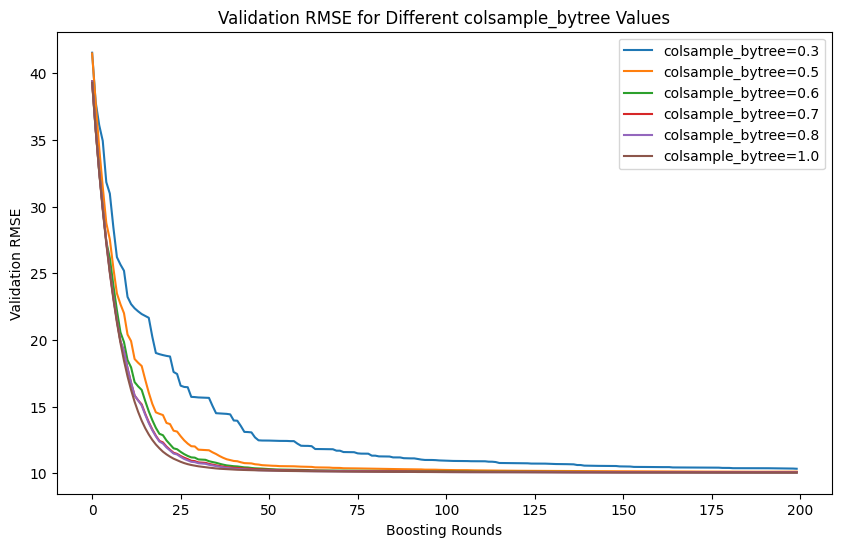

Final RMSE for colsample_bytree=0.3: 10.330670018689629
Final RMSE for colsample_bytree=0.5: 10.11377720998756
Final RMSE for colsample_bytree=0.6: 10.060891686205489
Final RMSE for colsample_bytree=0.7: 10.073783982025503
Final RMSE for colsample_bytree=0.8: 10.049616412475793
Final RMSE for colsample_bytree=1.0: 10.036234369395217


In [115]:
def train_xgboost_with_colsample_bytree(colsample_bytree, num_boost_round, gamma = 0.1, eta=0.1, max_depth=6,  min_child_weight=15, subsample=0.8, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                    
        'max_depth': max_depth,         
        'gamma': gamma,                  
        'subsample': subsample,        
        'colsample_bytree': colsample_bytree,  
        'min_child_weight': min_child_weight, 
        'objective': 'reg:squarederror', 
        'nthread': -1,   
        'seed': 1,                 
        'verbosity': 1,                
        'eval_metric': 'rmse'         
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model


colsample_bytree_values = [0.3, 0.5, 0.6, 0.7, 0.8, 1.0]
results_colsample_bytree = {}

for colsample_bytree in colsample_bytree_values:
    evals_result, model = train_xgboost_with_colsample_bytree(colsample_bytree=colsample_bytree, num_boost_round=200)
    results_colsample_bytree[colsample_bytree] = evals_result


plt.figure(figsize=(10, 6))

for colsample_bytree, evals_result in results_colsample_bytree.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'colsample_bytree={colsample_bytree}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different colsample_bytree Values')
plt.legend()
plt.show()


for colsample_bytree, evals_result in results_colsample_bytree.items():
    print(f"Final RMSE for colsample_bytree={colsample_bytree}: {evals_result['val']['rmse'][-1]}")


In [116]:
# final model
# Train the final model with optimal hyperparameters
xgb_params = {
    'eta': 0.1,                    
    'max_depth': 6,                
    'gamma': 0.1,                  
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'min_child_weight': 15,        
    'objective': 'reg:squarederror',
    'nthread': -1,                 
    'seed': 1,                     
    'verbosity': 1,                
    'eval_metric': 'rmse'                
}

In [117]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=[(dtrain, 'train'), (dval, 'val')],  # Monitor train and validation RMSE
    verbose_eval=5,  # Print every 5 rounds
    early_stopping_rounds=5  # Stop if no improvement for 10 rounds
)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")


[0]	train-rmse:39.70830	val-rmse:39.38724
[5]	train-rmse:25.17127	val-rmse:25.12730
[10]	train-rmse:17.72776	val-rmse:17.86364
[15]	train-rmse:14.11800	val-rmse:14.38222
[20]	train-rmse:11.84258	val-rmse:12.22692
[25]	train-rmse:10.74909	val-rmse:11.22110
[30]	train-rmse:10.21519	val-rmse:10.74393


[35]	train-rmse:9.97025	val-rmse:10.53757
[40]	train-rmse:9.75194	val-rmse:10.33905
[45]	train-rmse:9.63480	val-rmse:10.24870
[50]	train-rmse:9.55656	val-rmse:10.20111
[55]	train-rmse:9.51091	val-rmse:10.17652
[60]	train-rmse:9.46101	val-rmse:10.15381
[65]	train-rmse:9.42076	val-rmse:10.14401
[70]	train-rmse:9.38796	val-rmse:10.12878
[75]	train-rmse:9.36726	val-rmse:10.12076
[80]	train-rmse:9.33680	val-rmse:10.11514
[85]	train-rmse:9.31015	val-rmse:10.10595
[90]	train-rmse:9.28862	val-rmse:10.09814
[95]	train-rmse:9.26299	val-rmse:10.09130
[100]	train-rmse:9.23122	val-rmse:10.08366
[105]	train-rmse:9.20135	val-rmse:10.07724
[110]	train-rmse:9.18549	val-rmse:10.07598
[112]	train-rmse:9.17293	val-rmse:10.07653
Validation RMSE: 10.076525609809984


In [118]:

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=168
)

y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Final Validation RMSE: {rmse}")


Final Validation RMSE: 10.053731934188097


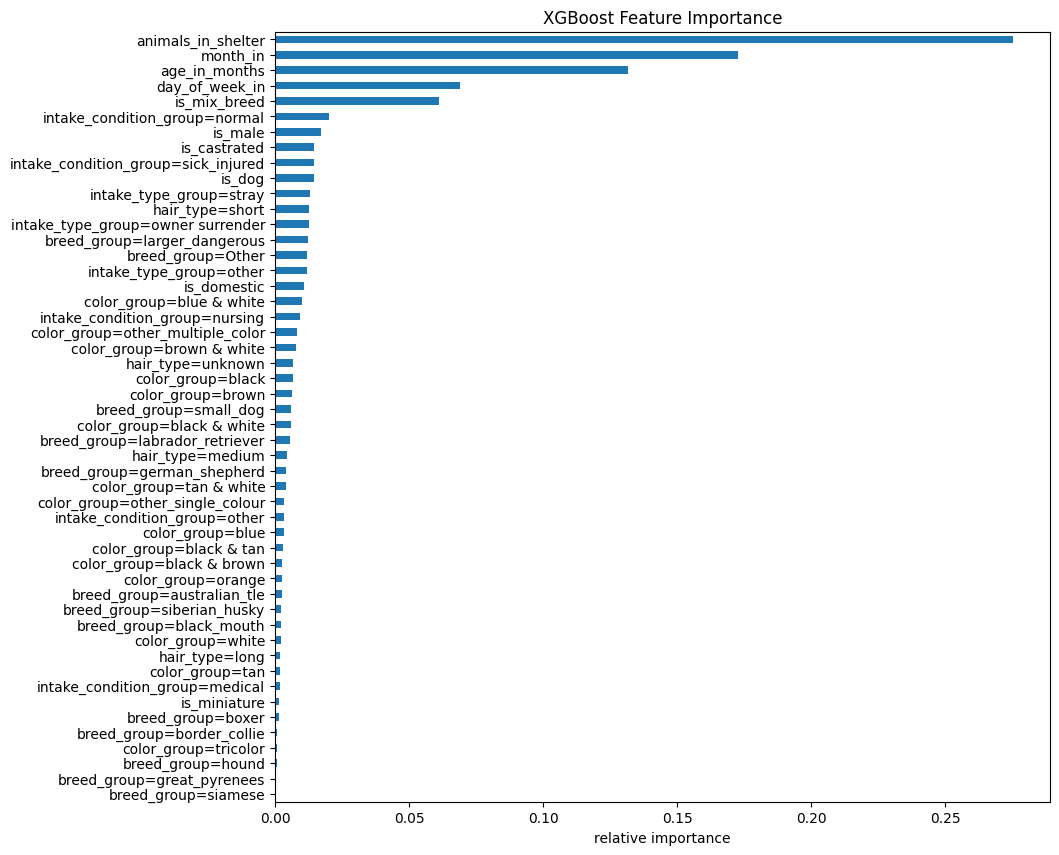

In [119]:
# feature importance
feature_importance = model.get_fscore()
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'fscore'])
df_feature_importance['fscore'] = df_feature_importance['fscore'] / df_feature_importance['fscore'].sum()

df_feature_importance = df_feature_importance.sort_values(by='fscore', ascending=True)  # Sort by fscore in descending order

df_feature_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.ylabel('')
plt.show()


In [120]:
# Make predictions on the test set with full training data
dtest = xgb.DMatrix(X_test, feature_names=features)
y_pred = model.predict(dtest)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}") 

Test RMSE: 10.151022580300928


seems that the best performer vs test is the xgboost so I will use it as a model